In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [ ]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [ ]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

Initialize the Neural Networks and Define the Optimizers

In [ ]:


generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
######################


In [ ]:
# optimizers

optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss()


In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# create the noise vector
# noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
path = "/content/drive/MyDrive/Deep_Learning/HW3/"
epochs = 200
k = 10

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(data_loader), total=int(len(fmnist)/data_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            # print(create_noise(b_size, nz).shape)
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, path + f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")




  0%|          | 0/117 [00:00<?, ?it/s]


  1%|          | 1/117 [00:00<00:14,  8.03it/s]


  2%|▏         | 2/117 [00:00<00:14,  7.86it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.75it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.85it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.82it/s]


  5%|▌         | 6/117 [00:00<00:13,  7.93it/s]


  6%|▌         | 7/117 [00:00<00:13,  7.99it/s]


  7%|▋         | 8/117 [00:01<00:13,  8.16it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.17it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.07it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.25it/s]


 10%|█         | 12/117 [00:01<00:12,  8.34it/s]


 11%|█         | 13/117 [00:01<00:12,  8.50it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.50it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.46it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.50it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.64it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.70it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.65it/

Epoch 0 of 200
Generator loss: 13.93749714, Discriminator loss: 0.00241676





  2%|▏         | 2/117 [00:00<00:13,  8.63it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.65it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.55it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.46it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.47it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.60it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.70it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.67it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.57it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.62it/s]


 10%|█         | 12/117 [00:01<00:12,  8.55it/s]


 11%|█         | 13/117 [00:01<00:12,  8.50it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.25it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.43it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.40it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.43it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.54it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.62it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.62it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 1 of 200
Generator loss: 21.75587654, Discriminator loss: 0.00283213





  2%|▏         | 2/117 [00:00<00:12,  9.00it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.57it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.65it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.55it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.62it/s]


  6%|▌         | 7/117 [00:00<00:12,  8.58it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.35it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.38it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.51it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.37it/s]


 10%|█         | 12/117 [00:01<00:12,  8.30it/s]


 11%|█         | 13/117 [00:01<00:12,  8.37it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.46it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.49it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.53it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.42it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.59it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.61it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.71it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 2 of 200
Generator loss: 19.11252975, Discriminator loss: 0.00396891





  2%|▏         | 2/117 [00:00<00:13,  8.74it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.59it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.63it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.55it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.25it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.46it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.72it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.09it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.30it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.44it/s]


 10%|█         | 12/117 [00:01<00:12,  8.45it/s]


 11%|█         | 13/117 [00:01<00:12,  8.43it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.31it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.37it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.48it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.40it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.44it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.53it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.40it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 3 of 200
Generator loss: 17.36197853, Discriminator loss: 0.00404722





  2%|▏         | 2/117 [00:00<00:13,  8.34it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.34it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.48it/s]


  4%|▍         | 5/117 [00:00<00:12,  8.64it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.48it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.36it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.45it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.43it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.51it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.37it/s]


 10%|█         | 12/117 [00:01<00:12,  8.47it/s]


 11%|█         | 13/117 [00:01<00:12,  8.59it/s]


 12%|█▏        | 14/117 [00:01<00:11,  8.61it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.47it/s]


 14%|█▎        | 16/117 [00:01<00:11,  8.48it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.59it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.73it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.73it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.53it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 4 of 200
Generator loss: 15.43149185, Discriminator loss: 0.01346259





  2%|▏         | 2/117 [00:00<00:13,  8.74it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.73it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.56it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.55it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.57it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.46it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.36it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.52it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.61it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.25it/s]


 10%|█         | 12/117 [00:01<00:12,  8.27it/s]


 11%|█         | 13/117 [00:01<00:12,  8.43it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.30it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.43it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.35it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.92it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.00it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.03it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.22it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 5 of 200
Generator loss: 17.09386826, Discriminator loss: 0.00991415





  2%|▏         | 2/117 [00:00<00:13,  8.58it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.69it/s]


  3%|▎         | 4/117 [00:00<00:12,  8.81it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.33it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.36it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.42it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.60it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.47it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.52it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.57it/s]


 10%|█         | 12/117 [00:01<00:12,  8.53it/s]


 11%|█         | 13/117 [00:01<00:12,  8.55it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.44it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.14it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.10it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.24it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.32it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.28it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.04it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 6 of 200
Generator loss: 16.04751587, Discriminator loss: 0.03099139





  2%|▏         | 2/117 [00:00<00:13,  8.40it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.28it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.33it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.33it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.43it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.41it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.33it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.13it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.23it/s]


 10%|█         | 12/117 [00:01<00:12,  8.47it/s]


 11%|█         | 13/117 [00:01<00:12,  8.37it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.43it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.23it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.03it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.86it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.93it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.96it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.21it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 7 of 200
Generator loss: 17.27824402, Discriminator loss: 0.01658344





  2%|▏         | 2/117 [00:00<00:13,  8.44it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.47it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.42it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.40it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.47it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.42it/s]


  7%|▋         | 8/117 [00:00<00:12,  8.46it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.62it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.70it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.35it/s]


 10%|█         | 12/117 [00:01<00:12,  8.32it/s]


 11%|█         | 13/117 [00:01<00:12,  8.24it/s]


 12%|█▏        | 14/117 [00:01<00:12,  7.99it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.90it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.02it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.17it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.12it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.00it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.04it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 8 of 200
Generator loss: 16.46572113, Discriminator loss: 0.02962723





  2%|▏         | 2/117 [00:00<00:14,  7.77it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.69it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.74it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.88it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.83it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.77it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.91it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.82it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.08it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.23it/s]


 10%|█         | 12/117 [00:01<00:12,  8.19it/s]


 11%|█         | 13/117 [00:01<00:12,  8.08it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.16it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.04it/s]


 14%|█▎        | 16/117 [00:02<00:12,  8.05it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.07it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.22it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.26it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.04it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 9 of 200
Generator loss: 18.63575363, Discriminator loss: 0.00598551





  2%|▏         | 2/117 [00:00<00:12,  9.15it/s]


  3%|▎         | 3/117 [00:00<00:12,  8.89it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.53it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.37it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.50it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.16it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.07it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.27it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.35it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.37it/s]


 10%|█         | 12/117 [00:01<00:12,  8.29it/s]


 11%|█         | 13/117 [00:01<00:12,  8.12it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.11it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.11it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.20it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.32it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.22it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.25it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.29it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 10 of 200
Generator loss: 22.23000908, Discriminator loss: 0.03148332





  2%|▏         | 2/117 [00:00<00:14,  8.10it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.18it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.93it/s]


  4%|▍         | 5/117 [00:00<00:14,  8.00it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.10it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.16it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.22it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.28it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.19it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.33it/s]


 10%|█         | 12/117 [00:01<00:12,  8.42it/s]


 11%|█         | 13/117 [00:01<00:12,  8.53it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.35it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.26it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.37it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.45it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.23it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.02it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.11it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 11 of 200
Generator loss: 18.61814690, Discriminator loss: 0.02712451





  2%|▏         | 2/117 [00:00<00:13,  8.67it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.42it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.58it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.59it/s]


  5%|▌         | 6/117 [00:00<00:12,  8.60it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.38it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.21it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.31it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.19it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.99it/s]


 10%|█         | 12/117 [00:01<00:13,  7.99it/s]


 11%|█         | 13/117 [00:01<00:13,  7.93it/s]


 12%|█▏        | 14/117 [00:01<00:12,  7.93it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.02it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.12it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.08it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.15it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.97it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.05it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 12 of 200
Generator loss: 23.50074959, Discriminator loss: 0.18086264





  2%|▏         | 2/117 [00:00<00:13,  8.67it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.45it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.44it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.33it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.07it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.17it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.18it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.18it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.12it/s]


  9%|▉         | 11/117 [00:01<00:13,  8.13it/s]


 10%|█         | 12/117 [00:01<00:13,  7.87it/s]


 11%|█         | 13/117 [00:01<00:12,  8.03it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.06it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.04it/s]


 14%|█▎        | 16/117 [00:01<00:12,  7.89it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.99it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.10it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.15it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.14it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 13 of 200
Generator loss: 13.24470425, Discriminator loss: 0.02689146





  2%|▏         | 2/117 [00:00<00:13,  8.53it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.57it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.68it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.38it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.51it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.45it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.25it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.30it/s]


  9%|▊         | 10/117 [00:01<00:12,  8.30it/s]


  9%|▉         | 11/117 [00:01<00:13,  8.11it/s]


 10%|█         | 12/117 [00:01<00:12,  8.13it/s]


 11%|█         | 13/117 [00:01<00:12,  8.20it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.20it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.25it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.19it/s]


 15%|█▍        | 17/117 [00:02<00:11,  8.35it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.18it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.28it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.32it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 14 of 200
Generator loss: 13.74881744, Discriminator loss: 0.02660992





  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.98it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.14it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.24it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.91it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.11it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.14it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.02it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.10it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.96it/s]


 10%|█         | 12/117 [00:01<00:13,  7.93it/s]


 11%|█         | 13/117 [00:01<00:12,  8.08it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.11it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.98it/s]


 14%|█▎        | 16/117 [00:01<00:12,  7.98it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.99it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.70it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.69it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.75it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 15 of 200
Generator loss: 18.07348061, Discriminator loss: 0.04819389





  2%|▏         | 2/117 [00:00<00:13,  8.25it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.36it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.30it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.35it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.28it/s]


  6%|▌         | 7/117 [00:00<00:13,  8.20it/s]


  7%|▋         | 8/117 [00:00<00:13,  8.30it/s]


  8%|▊         | 9/117 [00:01<00:12,  8.35it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.02it/s]


  9%|▉         | 11/117 [00:01<00:13,  8.02it/s]


 10%|█         | 12/117 [00:01<00:12,  8.10it/s]


 11%|█         | 13/117 [00:01<00:12,  8.07it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.00it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.93it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.12it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.86it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.87it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.79it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.83it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 16 of 200
Generator loss: 13.61048889, Discriminator loss: 0.03008154





  2%|▏         | 2/117 [00:00<00:13,  8.38it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.52it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.21it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.15it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.24it/s]


  6%|▌         | 7/117 [00:00<00:13,  7.99it/s]


  7%|▋         | 8/117 [00:00<00:13,  7.94it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.87it/s]


  9%|▊         | 10/117 [00:01<00:13,  8.04it/s]


  9%|▉         | 11/117 [00:01<00:12,  8.21it/s]


 10%|█         | 12/117 [00:01<00:12,  8.09it/s]


 11%|█         | 13/117 [00:01<00:12,  8.26it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.12it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.91it/s]


 14%|█▎        | 16/117 [00:01<00:12,  8.11it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.14it/s]


 15%|█▌        | 18/117 [00:02<00:11,  8.31it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.43it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.29it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 17 of 200
Generator loss: 15.12905693, Discriminator loss: 0.18364473





  2%|▏         | 2/117 [00:00<00:13,  8.30it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.24it/s]


  3%|▎         | 4/117 [00:00<00:14,  8.04it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.93it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.80it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.81it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.85it/s]


  8%|▊         | 9/117 [00:01<00:13,  8.00it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.97it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.94it/s]


 10%|█         | 12/117 [00:01<00:12,  8.08it/s]


 11%|█         | 13/117 [00:01<00:12,  8.10it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.06it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.96it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.93it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.10it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.13it/s]


 16%|█▌        | 19/117 [00:02<00:11,  8.29it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.19it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 18 of 200
Generator loss: 11.89956093, Discriminator loss: 0.05947836





  2%|▏         | 2/117 [00:00<00:15,  7.22it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.39it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.64it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.72it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.66it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.68it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.69it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.73it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.94it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.83it/s]


 10%|█         | 12/117 [00:01<00:13,  7.75it/s]


 11%|█         | 13/117 [00:01<00:13,  7.87it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.50it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.63it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.74it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.60it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.77it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.81it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.90it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 19 of 200
Generator loss: 19.54993439, Discriminator loss: 0.11568917





  2%|▏         | 2/117 [00:00<00:14,  7.89it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.74it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.75it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.75it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.71it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.73it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.89it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.78it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.82it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.66it/s]


 10%|█         | 12/117 [00:01<00:13,  7.79it/s]


 11%|█         | 13/117 [00:01<00:13,  7.88it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.02it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.99it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.77it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.86it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.84it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.62it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.45it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 20 of 200
Generator loss: 12.99688911, Discriminator loss: 0.06295979





  2%|▏         | 2/117 [00:00<00:14,  7.81it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.91it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.96it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.81it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.73it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.57it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.77it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.88it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.90it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.92it/s]


 10%|█         | 12/117 [00:01<00:13,  7.90it/s]


 11%|█         | 13/117 [00:01<00:13,  7.72it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.79it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.68it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.86it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.99it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.08it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.96it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.03it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 21 of 200
Generator loss: 14.59081745, Discriminator loss: 1.26404810





  2%|▏         | 2/117 [00:00<00:13,  8.40it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.26it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.24it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.29it/s]


  5%|▌         | 6/117 [00:00<00:13,  8.18it/s]


  6%|▌         | 7/117 [00:00<00:13,  7.96it/s]


  7%|▋         | 8/117 [00:00<00:13,  7.95it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.75it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.93it/s]


  9%|▉         | 11/117 [00:01<00:13,  8.05it/s]


 10%|█         | 12/117 [00:01<00:13,  8.05it/s]


 11%|█         | 13/117 [00:01<00:13,  7.94it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.05it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.99it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.92it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.86it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.89it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.06it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.19it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 22 of 200
Generator loss: 11.33914948, Discriminator loss: 0.23562291





  2%|▏         | 2/117 [00:00<00:15,  7.65it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.83it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.87it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.93it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.80it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.83it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.90it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.51it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.52it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.74it/s]


 10%|█         | 12/117 [00:01<00:13,  7.90it/s]


 11%|█         | 13/117 [00:01<00:13,  7.97it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.73it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.82it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.82it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.86it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.93it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.02it/s]


 17%|█▋        | 20/117 [00:02<00:12,  8.07it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 23 of 200
Generator loss: 11.35833454, Discriminator loss: 0.39978954





  2%|▏         | 2/117 [00:00<00:14,  8.00it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.92it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.92it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.87it/s]


  5%|▌         | 6/117 [00:00<00:13,  7.94it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.82it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.76it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.82it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.79it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.89it/s]


 10%|█         | 12/117 [00:01<00:13,  8.03it/s]


 11%|█         | 13/117 [00:01<00:12,  8.16it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.17it/s]


 13%|█▎        | 15/117 [00:01<00:12,  8.03it/s]


 14%|█▎        | 16/117 [00:02<00:12,  8.06it/s]


 15%|█▍        | 17/117 [00:02<00:12,  8.07it/s]


 15%|█▌        | 18/117 [00:02<00:12,  8.04it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.85it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.97it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 24 of 200
Generator loss: 12.41012573, Discriminator loss: 0.71791196





  2%|▏         | 2/117 [00:00<00:14,  8.18it/s]


  3%|▎         | 3/117 [00:00<00:14,  8.07it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.82it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.86it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.87it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.67it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.76it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.81it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.97it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.97it/s]


 10%|█         | 12/117 [00:01<00:13,  7.84it/s]


 11%|█         | 13/117 [00:01<00:13,  7.81it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.90it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.80it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.81it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.90it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.98it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.95it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.96it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 25 of 200
Generator loss: 10.06211758, Discriminator loss: 0.08806820





  2%|▏         | 2/117 [00:00<00:15,  7.49it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.66it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.75it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.83it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.71it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.86it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.91it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.82it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.85it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.73it/s]


 10%|█         | 12/117 [00:01<00:13,  7.82it/s]


 11%|█         | 13/117 [00:01<00:13,  7.87it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.80it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.95it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.99it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.95it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.96it/s]


 16%|█▌        | 19/117 [00:02<00:12,  8.04it/s]


 17%|█▋        | 20/117 [00:02<00:11,  8.17it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 26 of 200
Generator loss: 12.69892120, Discriminator loss: 0.93352646





  2%|▏         | 2/117 [00:00<00:15,  7.40it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.44it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.33it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.39it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.51it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.66it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.61it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.59it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.31it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.36it/s]


 10%|█         | 12/117 [00:01<00:14,  7.38it/s]


 11%|█         | 13/117 [00:01<00:14,  7.39it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.43it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.56it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.58it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.28it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.38it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.54it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.46it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 27 of 200
Generator loss: 10.57353401, Discriminator loss: 0.19189648





  2%|▏         | 2/117 [00:00<00:14,  8.09it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.94it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.98it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.10it/s]


  5%|▌         | 6/117 [00:00<00:13,  7.98it/s]


  6%|▌         | 7/117 [00:00<00:13,  7.93it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.85it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.94it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.75it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.83it/s]


 10%|█         | 12/117 [00:01<00:13,  7.65it/s]


 11%|█         | 13/117 [00:01<00:13,  7.69it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.81it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.91it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.89it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.87it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.71it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.60it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.71it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 28 of 200
Generator loss: 11.24810028, Discriminator loss: 1.88466096





  2%|▏         | 2/117 [00:00<00:14,  7.78it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.71it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.80it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.77it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.79it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.67it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.65it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.77it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.48it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.59it/s]


 10%|█         | 12/117 [00:01<00:13,  7.71it/s]


 11%|█         | 13/117 [00:01<00:13,  7.81it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.69it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.80it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.78it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.73it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.75it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.98it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.99it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 29 of 200
Generator loss: 8.86409283, Discriminator loss: 0.07717025





  2%|▏         | 2/117 [00:00<00:15,  7.46it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.60it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.63it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.46it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.66it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.70it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.73it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.64it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.63it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.65it/s]


 10%|█         | 12/117 [00:01<00:13,  7.73it/s]


 11%|█         | 13/117 [00:01<00:13,  7.80it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.77it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.86it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.92it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.88it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.71it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.58it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.54it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 30 of 200
Generator loss: 17.00962639, Discriminator loss: 5.86771393





  2%|▏         | 2/117 [00:00<00:15,  7.43it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.39it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.56it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.64it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.79it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.82it/s]


  7%|▋         | 8/117 [00:01<00:13,  7.92it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.72it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.88it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.90it/s]


 10%|█         | 12/117 [00:01<00:13,  7.75it/s]


 11%|█         | 13/117 [00:01<00:13,  7.82it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.84it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.86it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.89it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.72it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.85it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.90it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.70it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 31 of 200
Generator loss: 10.78579712, Discriminator loss: 0.09380617





  2%|▏         | 2/117 [00:00<00:15,  7.56it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.52it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.61it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.72it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.73it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.46it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.36it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.38it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.36it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.40it/s]


 10%|█         | 12/117 [00:01<00:14,  7.43it/s]


 11%|█         | 13/117 [00:01<00:14,  7.42it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.39it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.39it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.42it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.41it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.59it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.66it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.83it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 32 of 200
Generator loss: 18.70964050, Discriminator loss: 3.92457032





  2%|▏         | 2/117 [00:00<00:14,  8.06it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.73it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.61it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.70it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.61it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.58it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.54it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.72it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.77it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.85it/s]


 10%|█         | 12/117 [00:01<00:13,  8.01it/s]


 11%|█         | 13/117 [00:01<00:12,  8.22it/s]


 12%|█▏        | 14/117 [00:01<00:12,  8.18it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.87it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.88it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.80it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.79it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.95it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.62it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 33 of 200
Generator loss: 11.88007832, Discriminator loss: 1.17255116





  2%|▏         | 2/117 [00:00<00:15,  7.42it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.43it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.40it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.54it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.58it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.73it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.71it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.55it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.40it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.48it/s]


 10%|█         | 12/117 [00:01<00:13,  7.52it/s]


 11%|█         | 13/117 [00:01<00:14,  7.28it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.41it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.44it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.52it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.46it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.43it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.45it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.43it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 34 of 200
Generator loss: 14.32904530, Discriminator loss: 0.86493087





  2%|▏         | 2/117 [00:00<00:14,  8.08it/s]


  3%|▎         | 3/117 [00:00<00:14,  8.01it/s]


  3%|▎         | 4/117 [00:00<00:14,  8.06it/s]


  4%|▍         | 5/117 [00:00<00:13,  8.07it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.50it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.50it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.55it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.48it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.61it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.70it/s]


 10%|█         | 12/117 [00:01<00:13,  7.68it/s]


 11%|█         | 13/117 [00:01<00:13,  7.75it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.74it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.70it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.72it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.68it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.65it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.67it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.68it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 35 of 200
Generator loss: 13.29236984, Discriminator loss: 1.15489447





  2%|▏         | 2/117 [00:00<00:13,  8.39it/s]


  3%|▎         | 3/117 [00:00<00:13,  8.25it/s]


  3%|▎         | 4/117 [00:00<00:13,  8.09it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.75it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.68it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.71it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.73it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.77it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.91it/s]


  9%|▉         | 11/117 [00:01<00:13,  8.04it/s]


 10%|█         | 12/117 [00:01<00:13,  7.98it/s]


 11%|█         | 13/117 [00:01<00:13,  7.81it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.57it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.63it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.64it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.70it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.82it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.86it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.80it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 36 of 200
Generator loss: 12.98327065, Discriminator loss: 1.02941167





  2%|▏         | 2/117 [00:00<00:14,  8.03it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.92it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.80it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.61it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.56it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.61it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.58it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.43it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.51it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.50it/s]


 10%|█         | 12/117 [00:01<00:14,  7.39it/s]


 11%|█         | 13/117 [00:01<00:13,  7.45it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.34it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.39it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.38it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.25it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.28it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.28it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.05it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 37 of 200
Generator loss: 9.32313824, Discriminator loss: 0.21531281





  2%|▏         | 2/117 [00:00<00:15,  7.58it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.78it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.90it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.70it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.65it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.64it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.44it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.35it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.52it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.53it/s]


 10%|█         | 12/117 [00:01<00:13,  7.59it/s]


 11%|█         | 13/117 [00:01<00:14,  7.35it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.34it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.37it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.35it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.40it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.28it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.40it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.40it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 38 of 200
Generator loss: 11.65991306, Discriminator loss: 2.63941717





  2%|▏         | 2/117 [00:00<00:15,  7.32it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.41it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.51it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.59it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.61it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.73it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.59it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.76it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.78it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.74it/s]


 10%|█         | 12/117 [00:01<00:13,  7.64it/s]


 11%|█         | 13/117 [00:01<00:13,  7.77it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.74it/s]


 13%|█▎        | 15/117 [00:01<00:12,  7.87it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.66it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.65it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.70it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.74it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.71it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 39 of 200
Generator loss: 8.12409306, Discriminator loss: 0.16466115





  2%|▏         | 2/117 [00:00<00:15,  7.55it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.61it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.51it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.49it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.59it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.54it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.88it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.12it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.38it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.39it/s]


 10%|█         | 12/117 [00:01<00:13,  7.52it/s]


 11%|█         | 13/117 [00:01<00:13,  7.47it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.61it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.63it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.63it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.60it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.69it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.55it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.62it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 40 of 200
Generator loss: 12.78022671, Discriminator loss: 3.57173419





  2%|▏         | 2/117 [00:00<00:14,  8.06it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.87it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.95it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.81it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.74it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.66it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.65it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.56it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.57it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.40it/s]


 10%|█         | 12/117 [00:01<00:14,  7.42it/s]


 11%|█         | 13/117 [00:01<00:13,  7.58it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.60it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.55it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.52it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.29it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.34it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.57it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.53it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 41 of 200
Generator loss: 8.15545654, Discriminator loss: 0.33288661





  2%|▏         | 2/117 [00:00<00:15,  7.33it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.48it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.66it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.65it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.71it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.67it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.69it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.87it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.97it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.80it/s]


 10%|█         | 12/117 [00:01<00:13,  7.87it/s]


 11%|█         | 13/117 [00:01<00:13,  7.91it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.82it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.79it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.77it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.88it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.87it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.83it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.92it/s]


 18%|█▊        | 21/117 [00:02<00:11

Epoch 42 of 200
Generator loss: 12.17600060, Discriminator loss: 3.66826749





  2%|▏         | 2/117 [00:00<00:15,  7.39it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.55it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.66it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.78it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.79it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.73it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.70it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.72it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.68it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.72it/s]


 10%|█         | 12/117 [00:01<00:13,  7.67it/s]


 11%|█         | 13/117 [00:01<00:14,  7.37it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.42it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.63it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.80it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.94it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.65it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.58it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.62it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 43 of 200
Generator loss: 8.82861233, Discriminator loss: 0.12971561





  2%|▏         | 2/117 [00:00<00:14,  7.96it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.66it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.69it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.72it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.80it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.53it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.42it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.39it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.37it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.37it/s]


 10%|█         | 12/117 [00:01<00:13,  7.53it/s]


 11%|█         | 13/117 [00:01<00:13,  7.46it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.59it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.63it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.50it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.58it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.44it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.21it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.21it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 44 of 200
Generator loss: 17.28959846, Discriminator loss: 3.66714239





  2%|▏         | 2/117 [00:00<00:14,  8.19it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.95it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.95it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.93it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.54it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.43it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.61it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.63it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.64it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.66it/s]


 10%|█         | 12/117 [00:01<00:13,  7.83it/s]


 11%|█         | 13/117 [00:01<00:13,  7.90it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.69it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.82it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.79it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.61it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.70it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.69it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.54it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 45 of 200
Generator loss: 22.36295128, Discriminator loss: 9.28787899





  2%|▏         | 2/117 [00:00<00:14,  7.68it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.69it/s]


  3%|▎         | 4/117 [00:00<00:14,  7.66it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.70it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.70it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.86it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.73it/s]


  8%|▊         | 9/117 [00:01<00:13,  7.82it/s]


  9%|▊         | 10/117 [00:01<00:13,  7.66it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.48it/s]


 10%|█         | 12/117 [00:01<00:14,  7.32it/s]


 11%|█         | 13/117 [00:01<00:13,  7.43it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.56it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.49it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.55it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.57it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.49it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.55it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.66it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 46 of 200
Generator loss: 11.24867821, Discriminator loss: 0.97144043





  2%|▏         | 2/117 [00:00<00:16,  7.17it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.27it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.50it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.48it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.59it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.30it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.43it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.43it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.51it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.55it/s]


 10%|█         | 12/117 [00:01<00:13,  7.59it/s]


 11%|█         | 13/117 [00:01<00:13,  7.75it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.92it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.77it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.59it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.70it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.44it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.36it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.53it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 47 of 200
Generator loss: 10.26131439, Discriminator loss: 0.30888000





  2%|▏         | 2/117 [00:00<00:14,  7.85it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.56it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.45it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.35it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.30it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.34it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.49it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.39it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.53it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.39it/s]


 10%|█         | 12/117 [00:01<00:13,  7.50it/s]


 11%|█         | 13/117 [00:01<00:13,  7.60it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.53it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.52it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.56it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.62it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.55it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.59it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.52it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 48 of 200
Generator loss: 17.40865326, Discriminator loss: 6.79768372





  2%|▏         | 2/117 [00:00<00:15,  7.42it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.51it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.47it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.26it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.24it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.32it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.40it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.36it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.40it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.39it/s]


 10%|█         | 12/117 [00:01<00:14,  7.41it/s]


 11%|█         | 13/117 [00:01<00:14,  7.00it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.06it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.10it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.13it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.31it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.61it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.59it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.54it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 49 of 200
Generator loss: 9.68812847, Discriminator loss: 0.46501055





  2%|▏         | 2/117 [00:00<00:15,  7.44it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.52it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.26it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.33it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.24it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.37it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.38it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.31it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.42it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.53it/s]


 10%|█         | 12/117 [00:01<00:14,  7.34it/s]


 11%|█         | 13/117 [00:01<00:14,  7.21it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.22it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.20it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.23it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.35it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.37it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.34it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.27it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 50 of 200
Generator loss: 9.23126316, Discriminator loss: 0.10721712





  2%|▏         | 2/117 [00:00<00:15,  7.33it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.34it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.47it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.58it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.44it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.45it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.54it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.44it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.53it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.67it/s]


 10%|█         | 12/117 [00:01<00:13,  7.65it/s]


 11%|█         | 13/117 [00:01<00:13,  7.69it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.77it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.78it/s]


 14%|█▎        | 16/117 [00:02<00:12,  7.87it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.64it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.60it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.68it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.98it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 51 of 200
Generator loss: 11.67595005, Discriminator loss: 7.86484623





  2%|▏         | 2/117 [00:00<00:15,  7.21it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.17it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.29it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.31it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.29it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.28it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.41it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.30it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.41it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.54it/s]


 10%|█         | 12/117 [00:01<00:14,  7.46it/s]


 11%|█         | 13/117 [00:01<00:13,  7.59it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.82it/s]


 13%|█▎        | 15/117 [00:02<00:12,  7.88it/s]


 14%|█▎        | 16/117 [00:02<00:12,  8.02it/s]


 15%|█▍        | 17/117 [00:02<00:12,  7.95it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.89it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.76it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.46it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 52 of 200
Generator loss: 8.28716469, Discriminator loss: 0.16562599





  2%|▏         | 2/117 [00:00<00:15,  7.37it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.38it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.33it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.43it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.35it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.44it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.56it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.49it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.53it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.61it/s]


 10%|█         | 12/117 [00:01<00:13,  7.72it/s]


 11%|█         | 13/117 [00:01<00:13,  7.76it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.86it/s]


 13%|█▎        | 15/117 [00:01<00:13,  7.48it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.42it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.59it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.47it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.54it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.73it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 53 of 200
Generator loss: 11.55729675, Discriminator loss: 3.63281918





  2%|▏         | 2/117 [00:00<00:13,  8.23it/s]


  3%|▎         | 3/117 [00:00<00:14,  8.02it/s]


  3%|▎         | 4/117 [00:00<00:14,  8.05it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.74it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.73it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.62it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.60it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.63it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.53it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.39it/s]


 10%|█         | 12/117 [00:01<00:14,  7.10it/s]


 11%|█         | 13/117 [00:01<00:14,  7.13it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.15it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.45it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.48it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.59it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.54it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.67it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.49it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 54 of 200
Generator loss: 8.35739040, Discriminator loss: 0.12133653





  2%|▏         | 2/117 [00:00<00:15,  7.53it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.54it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.37it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.26it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.11it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.14it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.94it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.14it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.24it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.37it/s]


 10%|█         | 12/117 [00:01<00:13,  7.51it/s]


 11%|█         | 13/117 [00:01<00:13,  7.64it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.61it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.50it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.51it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.62it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.58it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.32it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.42it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 55 of 200
Generator loss: 9.92438889, Discriminator loss: 3.15317655





  2%|▏         | 2/117 [00:00<00:16,  6.95it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.05it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.07it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.32it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.38it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.20it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.05it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.92it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.01it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.26it/s]


 10%|█         | 12/117 [00:01<00:14,  7.34it/s]


 11%|█         | 13/117 [00:01<00:14,  7.34it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.37it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.39it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.35it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.22it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.34it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.47it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.56it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 56 of 200
Generator loss: 8.37961960, Discriminator loss: 0.18739367





  2%|▏         | 2/117 [00:00<00:16,  6.94it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.89it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.03it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.09it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.80it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.86it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.90it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.97it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.88it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.73it/s]


 10%|█         | 12/117 [00:01<00:15,  6.83it/s]


 11%|█         | 13/117 [00:01<00:15,  6.70it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.68it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.68it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.63it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.66it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.77it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.88it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.85it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 57 of 200
Generator loss: 10.52528381, Discriminator loss: 3.18144774





  2%|▏         | 2/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.87it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.96it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.91it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.97it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.08it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.95it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.92it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.90it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.84it/s]


 10%|█         | 12/117 [00:01<00:15,  6.82it/s]


 11%|█         | 13/117 [00:01<00:15,  6.89it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.12it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.99it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.96it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.87it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.97it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.02it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.94it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 58 of 200
Generator loss: 9.18928432, Discriminator loss: 0.46212810





  2%|▏         | 2/117 [00:00<00:17,  6.43it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.65it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.76it/s]


  4%|▍         | 5/117 [00:00<00:16,  7.00it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.15it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.05it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.96it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.78it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.87it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.90it/s]


 10%|█         | 12/117 [00:01<00:14,  7.03it/s]


 11%|█         | 13/117 [00:01<00:14,  7.10it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.87it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.88it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.69it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.87it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.89it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.84it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 59 of 200
Generator loss: 12.36758137, Discriminator loss: 2.53174520





  2%|▏         | 2/117 [00:00<00:15,  7.37it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.24it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.00it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.00it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.86it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.67it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.63it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.59it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.69it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.79it/s]


 10%|█         | 12/117 [00:01<00:15,  6.67it/s]


 11%|█         | 13/117 [00:01<00:15,  6.81it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.88it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.95it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.94it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.77it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.73it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.67it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 60 of 200
Generator loss: 7.94243908, Discriminator loss: 0.24039587





  2%|▏         | 2/117 [00:00<00:16,  7.16it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.15it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.20it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.23it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.31it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.32it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.21it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.22it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.37it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.26it/s]


 10%|█         | 12/117 [00:01<00:14,  7.22it/s]


 11%|█         | 13/117 [00:01<00:14,  7.16it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.21it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.17it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.22it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.30it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.15it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.15it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.23it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 61 of 200
Generator loss: 10.96730232, Discriminator loss: 3.82416034





  2%|▏         | 2/117 [00:00<00:17,  6.46it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.45it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.35it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.47it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.55it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.82it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.92it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.77it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.73it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.94it/s]


 10%|█         | 12/117 [00:01<00:14,  7.10it/s]


 11%|█         | 13/117 [00:01<00:14,  7.29it/s]


 12%|█▏        | 14/117 [00:02<00:13,  7.43it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.36it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.28it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.21it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.13it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.20it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.28it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 62 of 200
Generator loss: 8.50949287, Discriminator loss: 0.57093900





  2%|▏         | 2/117 [00:00<00:16,  6.90it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.00it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.98it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.81it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.96it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.10it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.24it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.24it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.91it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.96it/s]


 10%|█         | 12/117 [00:01<00:15,  6.87it/s]


 11%|█         | 13/117 [00:01<00:14,  6.96it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.12it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.09it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.92it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.07it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.12it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.98it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.09it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 63 of 200
Generator loss: 9.48664570, Discriminator loss: 0.28618184





  2%|▏         | 2/117 [00:00<00:16,  7.00it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.22it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.22it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.30it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.45it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.47it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.42it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.28it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.35it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.36it/s]


 10%|█         | 12/117 [00:01<00:14,  7.35it/s]


 11%|█         | 13/117 [00:01<00:14,  7.42it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.52it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.60it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.58it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.68it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.71it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.41it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.46it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 64 of 200
Generator loss: 9.48337078, Discriminator loss: 0.43383649





  2%|▏         | 2/117 [00:00<00:16,  7.08it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.22it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.79it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.73it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.88it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.95it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.08it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.26it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.35it/s]


 10%|█         | 12/117 [00:01<00:13,  7.54it/s]


 11%|█         | 13/117 [00:01<00:13,  7.54it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.48it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.58it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.21it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.18it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.05it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.99it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.04it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 65 of 200
Generator loss: 11.62051487, Discriminator loss: 3.13152695





  2%|▏         | 2/117 [00:00<00:14,  7.83it/s]


  3%|▎         | 3/117 [00:00<00:14,  7.62it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.53it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.15it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.09it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.09it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.16it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.13it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.14it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.17it/s]


 10%|█         | 12/117 [00:01<00:14,  7.17it/s]


 11%|█         | 13/117 [00:01<00:14,  7.24it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.21it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.32it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.45it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.62it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.58it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.54it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.60it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 66 of 200
Generator loss: 8.87166977, Discriminator loss: 0.28930187





  2%|▏         | 2/117 [00:00<00:16,  6.93it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.91it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.76it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.06it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.00it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.99it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.19it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.28it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.43it/s]


  9%|▉         | 11/117 [00:01<00:13,  7.66it/s]


 10%|█         | 12/117 [00:01<00:13,  7.67it/s]


 11%|█         | 13/117 [00:01<00:13,  7.64it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.44it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.46it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.37it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.46it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.54it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.36it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.21it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 67 of 200
Generator loss: 10.29991817, Discriminator loss: 0.62262374





  2%|▏         | 2/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.67it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.77it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.87it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.93it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.86it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.90it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.93it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.74it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.50it/s]


 10%|█         | 12/117 [00:01<00:16,  6.49it/s]


 11%|█         | 13/117 [00:01<00:16,  6.40it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.43it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.48it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.59it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.69it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.69it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.62it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.54it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 68 of 200
Generator loss: 11.15995026, Discriminator loss: 2.18817115





  2%|▏         | 2/117 [00:00<00:16,  7.16it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.31it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.36it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.33it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.34it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.37it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.23it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.22it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.34it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.37it/s]


 10%|█         | 12/117 [00:01<00:14,  7.40it/s]


 11%|█         | 13/117 [00:01<00:13,  7.44it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.30it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.33it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.34it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.46it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.33it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.38it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.51it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 69 of 200
Generator loss: 8.11542892, Discriminator loss: 0.77480644





  2%|▏         | 2/117 [00:00<00:15,  7.54it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.35it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.38it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.34it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.18it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.13it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.88it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.84it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.87it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.97it/s]


 10%|█         | 12/117 [00:01<00:15,  6.79it/s]


 11%|█         | 13/117 [00:01<00:15,  6.92it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.08it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.02it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.02it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.17it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.26it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.34it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.42it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 70 of 200
Generator loss: 11.30027390, Discriminator loss: 2.94892311





  2%|▏         | 2/117 [00:00<00:15,  7.42it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.38it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.39it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.42it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.54it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.40it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.33it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.45it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.53it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.35it/s]


 10%|█         | 12/117 [00:01<00:14,  7.29it/s]


 11%|█         | 13/117 [00:01<00:14,  7.29it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.27it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.17it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.11it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.75it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.95it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.13it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 71 of 200
Generator loss: 7.52005100, Discriminator loss: 0.40692532





  2%|▏         | 2/117 [00:00<00:16,  7.01it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.08it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.19it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.39it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.49it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.35it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.38it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.38it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.43it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.46it/s]


 10%|█         | 12/117 [00:01<00:14,  7.38it/s]


 11%|█         | 13/117 [00:01<00:14,  7.43it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.44it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.44it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.30it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.19it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.25it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.19it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.28it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 72 of 200
Generator loss: 11.88812065, Discriminator loss: 6.76059341





  2%|▏         | 2/117 [00:00<00:17,  6.76it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.64it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.72it/s]


  4%|▍         | 5/117 [00:00<00:16,  7.00it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.13it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.06it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.07it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.05it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.20it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.12it/s]


 10%|█         | 12/117 [00:01<00:14,  7.11it/s]


 11%|█         | 13/117 [00:01<00:14,  7.30it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.24it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.17it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.27it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.37it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.24it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.22it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.36it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 73 of 200
Generator loss: 8.46113014, Discriminator loss: 0.30657870





  2%|▏         | 2/117 [00:00<00:16,  7.08it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.15it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.21it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.42it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.19it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.15it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.31it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.31it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.38it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.40it/s]


 10%|█         | 12/117 [00:01<00:14,  7.46it/s]


 11%|█         | 13/117 [00:01<00:14,  7.41it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.42it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.46it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.49it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.53it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.64it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.61it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.57it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 74 of 200
Generator loss: 9.83367634, Discriminator loss: 0.65071630





  2%|▏         | 2/117 [00:00<00:16,  7.03it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.21it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.38it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.53it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.55it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.36it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.39it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.33it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.45it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.47it/s]


 10%|█         | 12/117 [00:01<00:13,  7.60it/s]


 11%|█         | 13/117 [00:01<00:13,  7.57it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.53it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.55it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.46it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.40it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.41it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.51it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.56it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 75 of 200
Generator loss: 8.85092640, Discriminator loss: 0.29443648





  2%|▏         | 2/117 [00:00<00:15,  7.21it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.37it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.38it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.46it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.53it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.31it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.33it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.43it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.24it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.32it/s]


 10%|█         | 12/117 [00:01<00:14,  7.47it/s]


 11%|█         | 13/117 [00:01<00:14,  7.42it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.37it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.26it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.28it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.24it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.17it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.20it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.23it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 76 of 200
Generator loss: 11.28384876, Discriminator loss: 4.25052691





  2%|▏         | 2/117 [00:00<00:16,  6.93it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.95it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.17it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.27it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.23it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.41it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.59it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.83it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.86it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.12it/s]


 10%|█         | 12/117 [00:01<00:14,  7.32it/s]


 11%|█         | 13/117 [00:01<00:14,  7.18it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.24it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.24it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.29it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.35it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.39it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.50it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.51it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 77 of 200
Generator loss: 9.08911133, Discriminator loss: 0.58678126





  2%|▏         | 2/117 [00:00<00:15,  7.27it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.14it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.90it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.01it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.08it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.94it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.08it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.15it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.92it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.02it/s]


 10%|█         | 12/117 [00:01<00:15,  7.00it/s]


 11%|█         | 13/117 [00:01<00:14,  6.95it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.88it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.02it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.10it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.10it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.08it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.11it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.07it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 78 of 200
Generator loss: 10.17489529, Discriminator loss: 0.51526976





  2%|▏         | 2/117 [00:00<00:17,  6.73it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.79it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.90it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.90it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.97it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.05it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.18it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.18it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.11it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.12it/s]


 10%|█         | 12/117 [00:01<00:14,  7.24it/s]


 11%|█         | 13/117 [00:01<00:14,  7.37it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.33it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.31it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.31it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.12it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.23it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.23it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.38it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 79 of 200
Generator loss: 8.53346539, Discriminator loss: 1.15617883





  2%|▏         | 2/117 [00:00<00:15,  7.31it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.29it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.31it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.33it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.28it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.06it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.05it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.09it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.09it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.21it/s]


 10%|█         | 12/117 [00:01<00:14,  7.30it/s]


 11%|█         | 13/117 [00:01<00:14,  7.27it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.23it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.34it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.36it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.39it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.45it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.49it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.45it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 80 of 200
Generator loss: 8.79832840, Discriminator loss: 0.89405262





  2%|▏         | 2/117 [00:00<00:16,  7.06it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.25it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.39it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.43it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.48it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.24it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.23it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.32it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.42it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.44it/s]


 10%|█         | 12/117 [00:01<00:14,  7.34it/s]


 11%|█         | 13/117 [00:01<00:13,  7.46it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.36it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.41it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.56it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.50it/s]


 15%|█▌        | 18/117 [00:02<00:12,  7.71it/s]


 16%|█▌        | 19/117 [00:02<00:12,  7.67it/s]


 17%|█▋        | 20/117 [00:02<00:12,  7.51it/s]


 18%|█▊        | 21/117 [00:02<00:12

Epoch 81 of 200
Generator loss: 10.36746025, Discriminator loss: 2.76932573





  2%|▏         | 2/117 [00:00<00:15,  7.34it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.43it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.38it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.34it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.48it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.55it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.28it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.29it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.16it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.99it/s]


 10%|█         | 12/117 [00:01<00:14,  7.08it/s]


 11%|█         | 13/117 [00:01<00:14,  7.04it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.15it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.27it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.32it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.26it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.32it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.18it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.30it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 82 of 200
Generator loss: 8.83721638, Discriminator loss: 0.93423760





  2%|▏         | 2/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.65it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.94it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.98it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.99it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.88it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.94it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.04it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.07it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.20it/s]


 10%|█         | 12/117 [00:01<00:14,  7.23it/s]


 11%|█         | 13/117 [00:01<00:14,  7.25it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.39it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.43it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.44it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.36it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.36it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.38it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.29it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 83 of 200
Generator loss: 9.88659382, Discriminator loss: 1.45900965





  2%|▏         | 2/117 [00:00<00:15,  7.38it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.19it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.22it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.15it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.14it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.04it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.15it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.19it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.17it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.28it/s]


 10%|█         | 12/117 [00:01<00:14,  7.37it/s]


 11%|█         | 13/117 [00:01<00:14,  7.38it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.05it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.19it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.25it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.33it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.24it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.16it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.35it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 84 of 200
Generator loss: 9.76584911, Discriminator loss: 0.56315917





  2%|▏         | 2/117 [00:00<00:16,  6.81it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.06it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.15it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.25it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.25it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.43it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.56it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.51it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.38it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.36it/s]


 10%|█         | 12/117 [00:01<00:14,  7.34it/s]


 11%|█         | 13/117 [00:01<00:14,  7.29it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.32it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.38it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.36it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.12it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.17it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.25it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.12it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 85 of 200
Generator loss: 9.53202152, Discriminator loss: 0.82455516





  2%|▏         | 2/117 [00:00<00:16,  7.18it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.26it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.38it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.13it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.17it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.19it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.27it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.13it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.10it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.20it/s]


 10%|█         | 12/117 [00:01<00:14,  7.30it/s]


 11%|█         | 13/117 [00:01<00:14,  7.36it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.34it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.33it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.30it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.10it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.17it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.22it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.17it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 86 of 200
Generator loss: 7.71943283, Discriminator loss: 0.32338926





  2%|▏         | 2/117 [00:00<00:16,  7.16it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.10it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.99it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.90it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.97it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.99it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.13it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.89it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.80it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.94it/s]


 10%|█         | 12/117 [00:01<00:14,  7.09it/s]


 11%|█         | 13/117 [00:01<00:14,  7.10it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.19it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.21it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.17it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.15it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.98it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.92it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.97it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 87 of 200
Generator loss: 9.27090168, Discriminator loss: 0.91323847





  2%|▏         | 2/117 [00:00<00:17,  6.75it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.65it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.84it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.88it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.89it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.84it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.00it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.85it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.91it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.85it/s]


 10%|█         | 12/117 [00:01<00:15,  6.99it/s]


 11%|█         | 13/117 [00:01<00:14,  7.11it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.95it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.90it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.78it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.94it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.09it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.14it/s]


 17%|█▋        | 20/117 [00:02<00:15,  6.23it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 88 of 200
Generator loss: 8.42401505, Discriminator loss: 0.25281131





  2%|▏         | 2/117 [00:00<00:15,  7.63it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.49it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.33it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.22it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.26it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.34it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.24it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.29it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.16it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.97it/s]


 10%|█         | 12/117 [00:01<00:15,  6.85it/s]


 11%|█         | 13/117 [00:01<00:14,  7.06it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.04it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.05it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.06it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.04it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.13it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.98it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.15it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 89 of 200
Generator loss: 11.02307701, Discriminator loss: 3.27633762





  2%|▏         | 2/117 [00:00<00:16,  7.15it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.35it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.39it/s]


  4%|▍         | 5/117 [00:00<00:14,  7.52it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.41it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.31it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.16it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.22it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.14it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.15it/s]


 10%|█         | 12/117 [00:01<00:14,  7.01it/s]


 11%|█         | 13/117 [00:01<00:14,  7.06it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.04it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.12it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.29it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.28it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.32it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.16it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.26it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 90 of 200
Generator loss: 7.35548258, Discriminator loss: 0.38398936





  2%|▏         | 2/117 [00:00<00:16,  7.06it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.02it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.11it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.08it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.13it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.20it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.39it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.34it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.23it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.40it/s]


 10%|█         | 12/117 [00:01<00:14,  7.30it/s]


 11%|█         | 13/117 [00:01<00:14,  7.26it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.31it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.26it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.34it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.19it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.23it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.30it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.32it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 91 of 200
Generator loss: 9.31921768, Discriminator loss: 2.16841197





  2%|▏         | 2/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.99it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.11it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.02it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.12it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.20it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.07it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.10it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.29it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.38it/s]


 10%|█         | 12/117 [00:01<00:14,  7.44it/s]


 11%|█         | 13/117 [00:01<00:14,  7.39it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.43it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.46it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.25it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.25it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.10it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.11it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.11it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 92 of 200
Generator loss: 8.85827160, Discriminator loss: 0.23434874





  2%|▏         | 2/117 [00:00<00:15,  7.30it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.21it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.27it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.35it/s]


  5%|▌         | 6/117 [00:00<00:14,  7.41it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.49it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.44it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.14it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.21it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.32it/s]


 10%|█         | 12/117 [00:01<00:14,  7.27it/s]


 11%|█         | 13/117 [00:01<00:14,  7.23it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.07it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.02it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.07it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.14it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.09it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.22it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.28it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 93 of 200
Generator loss: 11.17253113, Discriminator loss: 0.98312908





  2%|▏         | 2/117 [00:00<00:15,  7.37it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.30it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.39it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.31it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.35it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.25it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.33it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.30it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.29it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.18it/s]


 10%|█         | 12/117 [00:01<00:14,  7.25it/s]


 11%|█         | 13/117 [00:01<00:14,  7.26it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.17it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.11it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.05it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.09it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.27it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.25it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.27it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 94 of 200
Generator loss: 8.67304897, Discriminator loss: 0.34803867





  2%|▏         | 2/117 [00:00<00:16,  7.19it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.07it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.14it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.89it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.87it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.90it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.11it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.12it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.87it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.01it/s]


 10%|█         | 12/117 [00:01<00:14,  7.06it/s]


 11%|█         | 13/117 [00:01<00:14,  7.06it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.17it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.94it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.08it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.98it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.06it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.13it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 95 of 200
Generator loss: 10.71550274, Discriminator loss: 0.85762596





  2%|▏         | 2/117 [00:00<00:16,  6.84it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.06it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.23it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.31it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.12it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.23it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.25it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.19it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.02it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.15it/s]


 10%|█         | 12/117 [00:01<00:14,  7.28it/s]


 11%|█         | 13/117 [00:01<00:14,  7.32it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.32it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.25it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.22it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.10it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.20it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.21it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.38it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 96 of 200
Generator loss: 9.67318058, Discriminator loss: 1.00079107





  2%|▏         | 2/117 [00:00<00:18,  6.17it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.49it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.59it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.58it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.73it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.71it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.87it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.98it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.15it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.10it/s]


 10%|█         | 12/117 [00:01<00:14,  7.09it/s]


 11%|█         | 13/117 [00:01<00:14,  7.10it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.95it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.06it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.17it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.09it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.27it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.18it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.30it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 97 of 200
Generator loss: 9.91865063, Discriminator loss: 0.35086808





  2%|▏         | 2/117 [00:00<00:15,  7.31it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.07it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.20it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.29it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.11it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.12it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.20it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.10it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.14it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.23it/s]


 10%|█         | 12/117 [00:01<00:14,  7.27it/s]


 11%|█         | 13/117 [00:01<00:14,  7.12it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.19it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.29it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.19it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.93it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.07it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.14it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.03it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 98 of 200
Generator loss: 10.39777374, Discriminator loss: 0.89955097





  2%|▏         | 2/117 [00:00<00:16,  6.92it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.12it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.06it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.24it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.28it/s]


  7%|▋         | 8/117 [00:01<00:14,  7.30it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.18it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.02it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.87it/s]


 10%|█         | 12/117 [00:01<00:15,  6.88it/s]


 11%|█         | 13/117 [00:01<00:14,  6.98it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.07it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.10it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.03it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.02it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.12it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.03it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.07it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 99 of 200
Generator loss: 9.27371788, Discriminator loss: 2.10475183





  2%|▏         | 2/117 [00:00<00:17,  6.75it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.81it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.92it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.97it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.94it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.93it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.59it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.80it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.91it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.97it/s]


 10%|█         | 12/117 [00:01<00:14,  7.03it/s]


 11%|█         | 13/117 [00:01<00:15,  6.82it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.90it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.98it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.91it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.84it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.91it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.95it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.93it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 100 of 200
Generator loss: 9.09905148, Discriminator loss: 0.43269697





  2%|▏         | 2/117 [00:00<00:15,  7.25it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.18it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.13it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.26it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.18it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.16it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.19it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.22it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.26it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.17it/s]


 10%|█         | 12/117 [00:01<00:14,  7.14it/s]


 11%|█         | 13/117 [00:01<00:14,  7.31it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.22it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.36it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.25it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.15it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.20it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.24it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.33it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 101 of 200
Generator loss: 10.47031593, Discriminator loss: 2.09353757





  2%|▏         | 2/117 [00:00<00:15,  7.40it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.16it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.18it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.05it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.08it/s]


  6%|▌         | 7/117 [00:00<00:15,  6.96it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.04it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.10it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.10it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.06it/s]


 10%|█         | 12/117 [00:01<00:15,  6.99it/s]


 11%|█         | 13/117 [00:01<00:14,  7.07it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.02it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.06it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.13it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.14it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.22it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.26it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.36it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 102 of 200
Generator loss: 8.42897224, Discriminator loss: 0.41516015





  2%|▏         | 2/117 [00:00<00:16,  6.91it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.98it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.21it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.38it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.35it/s]


  6%|▌         | 7/117 [00:00<00:14,  7.37it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.98it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.11it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.23it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.32it/s]


 10%|█         | 12/117 [00:01<00:14,  7.18it/s]


 11%|█         | 13/117 [00:01<00:14,  7.18it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.15it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.99it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.05it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.10it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.11it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.20it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.22it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 103 of 200
Generator loss: 9.98656940, Discriminator loss: 0.76184934





  2%|▏         | 2/117 [00:00<00:16,  7.18it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.25it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.36it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.34it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.28it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.17it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.23it/s]


  8%|▊         | 9/117 [00:01<00:14,  7.27it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.29it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.22it/s]


 10%|█         | 12/117 [00:01<00:14,  7.31it/s]


 11%|█         | 13/117 [00:01<00:14,  7.26it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.27it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.02it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.79it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.96it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.03it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.03it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.96it/s]


 18%|█▊        | 21/117 [00:02<00:14

Epoch 104 of 200
Generator loss: 9.32525635, Discriminator loss: 0.43831196





  2%|▏         | 2/117 [00:00<00:15,  7.19it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.98it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.00it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.03it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.06it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.91it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.95it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.01it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.99it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.11it/s]


 10%|█         | 12/117 [00:01<00:14,  7.02it/s]


 11%|█         | 13/117 [00:01<00:14,  7.03it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.15it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.09it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.22it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.20it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.31it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.20it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.28it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 105 of 200
Generator loss: 8.71720028, Discriminator loss: 2.19115353





  2%|▏         | 2/117 [00:00<00:16,  7.12it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.16it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.17it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.13it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.23it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.18it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.20it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.19it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.27it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.32it/s]


 10%|█         | 12/117 [00:01<00:14,  7.40it/s]


 11%|█         | 13/117 [00:01<00:14,  7.21it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.34it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.22it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.18it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.25it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.29it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.30it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.96it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 106 of 200
Generator loss: 8.76695251, Discriminator loss: 1.03052175





  2%|▏         | 2/117 [00:00<00:16,  6.92it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.11it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.12it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.10it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.12it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.20it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.24it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.96it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.04it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.06it/s]


 10%|█         | 12/117 [00:01<00:14,  7.06it/s]


 11%|█         | 13/117 [00:01<00:14,  7.11it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.21it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.16it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.87it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.81it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.88it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.06it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.18it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 107 of 200
Generator loss: 8.50467968, Discriminator loss: 0.56693256





  2%|▏         | 2/117 [00:00<00:17,  6.60it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.60it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.75it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.80it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.86it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.76it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.80it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.66it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.88it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.97it/s]


 10%|█         | 12/117 [00:01<00:14,  7.19it/s]


 11%|█         | 13/117 [00:01<00:14,  7.18it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.12it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.04it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.92it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.93it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.89it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.97it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.97it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 108 of 200
Generator loss: 9.62213612, Discriminator loss: 0.52876449





  2%|▏         | 2/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.87it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.69it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.88it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.97it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.05it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.06it/s]


  9%|▊         | 10/117 [00:01<00:14,  7.17it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.23it/s]


 10%|█         | 12/117 [00:01<00:14,  7.21it/s]


 11%|█         | 13/117 [00:01<00:14,  7.29it/s]


 12%|█▏        | 14/117 [00:01<00:13,  7.41it/s]


 13%|█▎        | 15/117 [00:02<00:13,  7.43it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.27it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.29it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.20it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.41it/s]


 17%|█▋        | 20/117 [00:02<00:15,  6.34it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 109 of 200
Generator loss: 10.58715343, Discriminator loss: 0.50215626





  2%|▏         | 2/117 [00:00<00:16,  6.77it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.80it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.86it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.84it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.91it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.84it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.85it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.00it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.95it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.98it/s]


 10%|█         | 12/117 [00:01<00:15,  6.96it/s]


 11%|█         | 13/117 [00:01<00:14,  6.98it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.78it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.94it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.02it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.99it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.98it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.01it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.06it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 110 of 200
Generator loss: 9.84627533, Discriminator loss: 1.14858246





  2%|▏         | 2/117 [00:00<00:16,  6.91it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.76it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.67it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.80it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.98it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.91it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.89it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.07it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.19it/s]


 10%|█         | 12/117 [00:01<00:14,  7.13it/s]


 11%|█         | 13/117 [00:01<00:14,  7.08it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.09it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.19it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.73it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.79it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.69it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.86it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.89it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 111 of 200
Generator loss: 9.15181255, Discriminator loss: 0.39685884





  2%|▏         | 2/117 [00:00<00:17,  6.62it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.53it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.69it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.85it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.98it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.92it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.86it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.80it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.79it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.95it/s]


 10%|█         | 12/117 [00:01<00:14,  7.08it/s]


 11%|█         | 13/117 [00:01<00:14,  7.17it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.26it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.14it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.24it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.09it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.10it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.03it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.13it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 112 of 200
Generator loss: 8.99240208, Discriminator loss: 0.67400867





  2%|▏         | 2/117 [00:00<00:17,  6.41it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.67it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.87it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.94it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.09it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.04it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.03it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.04it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.88it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.01it/s]


 10%|█         | 12/117 [00:01<00:14,  7.07it/s]


 11%|█         | 13/117 [00:01<00:14,  7.24it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.07it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.01it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.17it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.18it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.11it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.21it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.20it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 113 of 200
Generator loss: 8.49518394, Discriminator loss: 1.30208945





  2%|▏         | 2/117 [00:00<00:17,  6.67it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.58it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.62it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.68it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.68it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.72it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.73it/s]


  8%|▊         | 9/117 [00:01<00:18,  5.87it/s]


  9%|▊         | 10/117 [00:01<00:18,  5.91it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.15it/s]


 10%|█         | 12/117 [00:01<00:17,  6.09it/s]


 11%|█         | 13/117 [00:02<00:16,  6.24it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.46it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.59it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.61it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.69it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.62it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.76it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.61it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 114 of 200
Generator loss: 9.19795609, Discriminator loss: 0.32928261





  2%|▏         | 2/117 [00:00<00:16,  6.98it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.81it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.93it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.05it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.12it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.18it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.09it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.06it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.93it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.84it/s]


 10%|█         | 12/117 [00:01<00:15,  6.81it/s]


 11%|█         | 13/117 [00:01<00:15,  6.90it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.04it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.08it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.88it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.86it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.79it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.87it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.87it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 115 of 200
Generator loss: 9.34441566, Discriminator loss: 1.10780394





  2%|▏         | 2/117 [00:00<00:17,  6.43it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.62it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.57it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.65it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.68it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.68it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.51it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.74it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.86it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.87it/s]


 10%|█         | 12/117 [00:01<00:15,  6.87it/s]


 11%|█         | 13/117 [00:01<00:14,  7.05it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.10it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.21it/s]


 14%|█▎        | 16/117 [00:02<00:13,  7.28it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.39it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.39it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.25it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.17it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 116 of 200
Generator loss: 10.13609409, Discriminator loss: 0.84499466





  2%|▏         | 2/117 [00:00<00:17,  6.52it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.53it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.72it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.79it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.83it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.92it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.05it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.83it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.85it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.93it/s]


 10%|█         | 12/117 [00:01<00:15,  6.93it/s]


 11%|█         | 13/117 [00:01<00:15,  6.87it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.87it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.85it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.80it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.81it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.80it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.83it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.92it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 117 of 200
Generator loss: 9.46266842, Discriminator loss: 0.71330708





  2%|▏         | 2/117 [00:00<00:16,  6.83it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.67it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.85it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.88it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.78it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.73it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.67it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.61it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.53it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.51it/s]


 10%|█         | 12/117 [00:01<00:15,  6.63it/s]


 11%|█         | 13/117 [00:01<00:15,  6.66it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.79it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.88it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.89it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.87it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.95it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.98it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.91it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 118 of 200
Generator loss: 9.31704521, Discriminator loss: 0.48254454





  2%|▏         | 2/117 [00:00<00:16,  7.09it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.02it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.58it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.54it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.53it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.53it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.63it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.77it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.78it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.74it/s]


 10%|█         | 12/117 [00:01<00:15,  6.87it/s]


 11%|█         | 13/117 [00:01<00:14,  6.94it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.03it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.11it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.10it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.13it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.04it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.10it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.14it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 119 of 200
Generator loss: 9.74161530, Discriminator loss: 1.47761536





  2%|▏         | 2/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.90it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.80it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.55it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.70it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.78it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.80it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.59it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.69it/s]


 10%|█         | 12/117 [00:01<00:15,  6.82it/s]


 11%|█         | 13/117 [00:01<00:15,  6.93it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.97it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.96it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.03it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.98it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.90it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.68it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.67it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 120 of 200
Generator loss: 8.49212933, Discriminator loss: 0.77649534





  2%|▏         | 2/117 [00:00<00:16,  6.92it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.74it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.86it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.96it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.99it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.74it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.65it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.69it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.72it/s]


 10%|█         | 12/117 [00:01<00:15,  6.75it/s]


 11%|█         | 13/117 [00:01<00:15,  6.76it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.82it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.90it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.73it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.91it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.95it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.95it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.88it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 121 of 200
Generator loss: 8.94669628, Discriminator loss: 0.49499246





  2%|▏         | 2/117 [00:00<00:18,  6.34it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.57it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.52it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.55it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.69it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.76it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.89it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.97it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.04it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.08it/s]


 10%|█         | 12/117 [00:01<00:15,  7.00it/s]


 11%|█         | 13/117 [00:01<00:14,  6.97it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.03it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.13it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.12it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.17it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.21it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.15it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.09it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 122 of 200
Generator loss: 9.45309830, Discriminator loss: 0.47926828





  2%|▏         | 2/117 [00:00<00:17,  6.66it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.81it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.88it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.82it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.83it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.87it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.81it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.81it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.74it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.82it/s]


 10%|█         | 12/117 [00:01<00:15,  6.77it/s]


 11%|█         | 13/117 [00:01<00:15,  6.88it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.95it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.85it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.75it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.86it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.87it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.94it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.83it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 123 of 200
Generator loss: 9.17643738, Discriminator loss: 0.65641737





  2%|▏         | 2/117 [00:00<00:16,  7.07it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.05it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.05it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.97it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.02it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.99it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.98it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.75it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.85it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.90it/s]


 10%|█         | 12/117 [00:01<00:14,  7.10it/s]


 11%|█         | 13/117 [00:01<00:14,  7.08it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.96it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.01it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.16it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.13it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.91it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.72it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.67it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 124 of 200
Generator loss: 9.13755989, Discriminator loss: 1.51223731





  2%|▏         | 2/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.05it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.09it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.07it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.90it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.01it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.00it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.02it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.99it/s]


 10%|█         | 12/117 [00:01<00:15,  6.94it/s]


 11%|█         | 13/117 [00:01<00:15,  6.75it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.77it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.63it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.72it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.92it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.94it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.72it/s]


 18%|█▊        | 21/117 [00:03<00:16

Epoch 125 of 200
Generator loss: 8.53205299, Discriminator loss: 0.52588248





  2%|▏         | 2/117 [00:00<00:17,  6.70it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.74it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.73it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.87it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.68it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.76it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.78it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.91it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.81it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.80it/s]


 10%|█         | 12/117 [00:01<00:15,  6.83it/s]


 11%|█         | 13/117 [00:01<00:15,  6.69it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.52it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.61it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.61it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.76it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.92it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.89it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.80it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 126 of 200
Generator loss: 9.11771870, Discriminator loss: 0.68691224





  2%|▏         | 2/117 [00:00<00:15,  7.22it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.08it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.09it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.99it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.94it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.03it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.01it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.89it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.80it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.79it/s]


 10%|█         | 12/117 [00:01<00:15,  6.99it/s]


 11%|█         | 13/117 [00:01<00:15,  6.84it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.03it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.13it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.07it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.05it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.93it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.90it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.79it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 127 of 200
Generator loss: 10.21294880, Discriminator loss: 1.36811674





  2%|▏         | 2/117 [00:00<00:17,  6.53it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.44it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.46it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.45it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.50it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.54it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.66it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.42it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.51it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.45it/s]


 10%|█         | 12/117 [00:01<00:15,  6.59it/s]


 11%|█         | 13/117 [00:02<00:16,  6.38it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.49it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.49it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.50it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.61it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.64it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.66it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.63it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 128 of 200
Generator loss: 8.54351044, Discriminator loss: 1.00109100





  2%|▏         | 2/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.90it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.90it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.63it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.76it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.91it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.97it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.88it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.92it/s]


 10%|█         | 12/117 [00:01<00:15,  6.87it/s]


 11%|█         | 13/117 [00:01<00:15,  6.79it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.78it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.93it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.03it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.08it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.02it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.88it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.85it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 129 of 200
Generator loss: 9.41883087, Discriminator loss: 0.41901556





  2%|▏         | 2/117 [00:00<00:17,  6.68it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.64it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.75it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.64it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.61it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.73it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.86it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.81it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.85it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.70it/s]


 10%|█         | 12/117 [00:01<00:15,  6.68it/s]


 11%|█         | 13/117 [00:01<00:15,  6.78it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.81it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.89it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.00it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.96it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.84it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.71it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.69it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 130 of 200
Generator loss: 8.58443642, Discriminator loss: 2.03934956





  2%|▏         | 2/117 [00:00<00:16,  6.85it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.85it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.87it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.83it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.80it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.89it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.63it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.59it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.67it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.73it/s]


 10%|█         | 12/117 [00:01<00:15,  6.75it/s]


 11%|█         | 13/117 [00:01<00:15,  6.79it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.84it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.77it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.79it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.89it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.86it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.71it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.71it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 131 of 200
Generator loss: 9.49064636, Discriminator loss: 0.47333786





  2%|▏         | 2/117 [00:00<00:17,  6.49it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.60it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.75it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.93it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.99it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.07it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.03it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.98it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.04it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.06it/s]


 10%|█         | 12/117 [00:01<00:15,  6.96it/s]


 11%|█         | 13/117 [00:01<00:15,  6.91it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.01it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.07it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.89it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.87it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.75it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.80it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.82it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 132 of 200
Generator loss: 8.59587193, Discriminator loss: 1.91819632





  2%|▏         | 2/117 [00:00<00:17,  6.67it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.79it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.82it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.77it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.75it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.85it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.99it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.08it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.10it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.12it/s]


 10%|█         | 12/117 [00:01<00:15,  6.99it/s]


 11%|█         | 13/117 [00:01<00:14,  7.09it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.09it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.06it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.17it/s]


 15%|█▍        | 17/117 [00:02<00:13,  7.25it/s]


 15%|█▌        | 18/117 [00:02<00:13,  7.32it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.07it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.20it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 133 of 200
Generator loss: 9.13952541, Discriminator loss: 0.48741329





  2%|▏         | 2/117 [00:00<00:16,  6.93it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.90it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.93it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.88it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.73it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.85it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.84it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.92it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.01it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.01it/s]


 10%|█         | 12/117 [00:01<00:15,  6.93it/s]


 11%|█         | 13/117 [00:01<00:15,  6.71it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.76it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.59it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.79it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.92it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.94it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.84it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.69it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 134 of 200
Generator loss: 9.75177956, Discriminator loss: 0.60177046





  2%|▏         | 2/117 [00:00<00:16,  6.81it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.78it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.61it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.52it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.60it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.61it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.56it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.47it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.50it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.57it/s]


 10%|█         | 12/117 [00:01<00:16,  6.48it/s]


 11%|█         | 13/117 [00:02<00:16,  6.34it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.43it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.53it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.55it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.54it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.64it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.81it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.74it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 135 of 200
Generator loss: 9.24610901, Discriminator loss: 0.83372635





  2%|▏         | 2/117 [00:00<00:17,  6.54it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.61it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.63it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.68it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.75it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.87it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.95it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.88it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.70it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.77it/s]


 10%|█         | 12/117 [00:01<00:15,  6.83it/s]


 11%|█         | 13/117 [00:01<00:15,  6.82it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.83it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.75it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.85it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.89it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.85it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.70it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.73it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 136 of 200
Generator loss: 8.63247871, Discriminator loss: 1.29067791





  2%|▏         | 2/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.91it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.93it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.03it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.10it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.23it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.20it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.17it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.82it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.98it/s]


 10%|█         | 12/117 [00:01<00:15,  6.89it/s]


 11%|█         | 13/117 [00:01<00:14,  6.93it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.95it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.92it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.81it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.72it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.72it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.73it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.71it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 137 of 200
Generator loss: 8.83416367, Discriminator loss: 0.81463635





  2%|▏         | 2/117 [00:00<00:16,  7.06it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.76it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.82it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.85it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.94it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.78it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.76it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.78it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.78it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.84it/s]


 10%|█         | 12/117 [00:01<00:15,  6.95it/s]


 11%|█         | 13/117 [00:01<00:14,  6.98it/s]


 12%|█▏        | 14/117 [00:02<00:14,  7.01it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.08it/s]


 14%|█▎        | 16/117 [00:02<00:14,  7.07it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.02it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.01it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.91it/s]


 17%|█▋        | 20/117 [00:02<00:13,  6.99it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 138 of 200
Generator loss: 9.25373173, Discriminator loss: 0.47923213





  2%|▏         | 2/117 [00:00<00:16,  7.05it/s]


  3%|▎         | 3/117 [00:00<00:16,  7.12it/s]


  3%|▎         | 4/117 [00:00<00:16,  7.04it/s]


  4%|▍         | 5/117 [00:00<00:15,  7.03it/s]


  5%|▌         | 6/117 [00:00<00:15,  7.10it/s]


  6%|▌         | 7/117 [00:00<00:15,  7.16it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.21it/s]


  8%|▊         | 9/117 [00:01<00:15,  7.10it/s]


  9%|▊         | 10/117 [00:01<00:15,  7.07it/s]


  9%|▉         | 11/117 [00:01<00:14,  7.10it/s]


 10%|█         | 12/117 [00:01<00:14,  7.09it/s]


 11%|█         | 13/117 [00:01<00:14,  7.08it/s]


 12%|█▏        | 14/117 [00:01<00:14,  7.17it/s]


 13%|█▎        | 15/117 [00:02<00:14,  7.03it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.83it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.83it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.97it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.94it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.80it/s]


 18%|█▊        | 21/117 [00:02<00:13

Epoch 139 of 200
Generator loss: 8.23782635, Discriminator loss: 0.94207615





  2%|▏         | 2/117 [00:00<00:16,  6.82it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.79it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.80it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.77it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.76it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.90it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.91it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.83it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.61it/s]


 10%|█         | 12/117 [00:01<00:15,  6.70it/s]


 11%|█         | 13/117 [00:01<00:15,  6.85it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.80it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.72it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.81it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.67it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.69it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.77it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 140 of 200
Generator loss: 8.67390919, Discriminator loss: 0.82241410





  2%|▏         | 2/117 [00:00<00:16,  6.94it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.73it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.54it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.60it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.61it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.60it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.64it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.80it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.87it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.72it/s]


 10%|█         | 12/117 [00:01<00:15,  6.71it/s]


 11%|█         | 13/117 [00:01<00:15,  6.73it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.80it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.89it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.89it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.78it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.61it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.65it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.78it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 141 of 200
Generator loss: 8.65592575, Discriminator loss: 0.69072032





  2%|▏         | 2/117 [00:00<00:17,  6.59it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.49it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.55it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.66it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.44it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.41it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.45it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.37it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.45it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.54it/s]


 10%|█         | 12/117 [00:01<00:15,  6.61it/s]


 11%|█         | 13/117 [00:02<00:15,  6.55it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.56it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.67it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.67it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.80it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.61it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.68it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.65it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 142 of 200
Generator loss: 8.76758099, Discriminator loss: 0.68581420





  2%|▏         | 2/117 [00:00<00:16,  6.77it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.74it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.63it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.50it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.54it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.58it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.62it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.63it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.67it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.70it/s]


 10%|█         | 12/117 [00:01<00:17,  6.17it/s]


 11%|█         | 13/117 [00:01<00:16,  6.37it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.48it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.58it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.53it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.52it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.44it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.58it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.71it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 143 of 200
Generator loss: 9.98607635, Discriminator loss: 0.47471455





  2%|▏         | 2/117 [00:00<00:16,  7.11it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.77it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.64it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.65it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.70it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.66it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.50it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.51it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.57it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.50it/s]


 10%|█         | 12/117 [00:01<00:15,  6.57it/s]


 11%|█         | 13/117 [00:01<00:15,  6.55it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.67it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.81it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.89it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.81it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.40it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.24it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.33it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 144 of 200
Generator loss: 9.16327667, Discriminator loss: 0.64593059





  2%|▏         | 2/117 [00:00<00:17,  6.61it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.64it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.64it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.64it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.65it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.54it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.63it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.38it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.42it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.45it/s]


 10%|█         | 12/117 [00:01<00:15,  6.56it/s]


 11%|█         | 13/117 [00:01<00:15,  6.51it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.55it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.64it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.49it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.68it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.68it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.76it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.77it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 145 of 200
Generator loss: 7.59358978, Discriminator loss: 0.81021190





  2%|▏         | 2/117 [00:00<00:17,  6.73it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.62it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.44it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.28it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.33it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.39it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.46it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.51it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.62it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.58it/s]


 10%|█         | 12/117 [00:01<00:15,  6.64it/s]


 11%|█         | 13/117 [00:02<00:15,  6.57it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.69it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.75it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.74it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.91it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.05it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.07it/s]


 17%|█▋        | 20/117 [00:03<00:13,  6.97it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 146 of 200
Generator loss: 9.42932034, Discriminator loss: 0.52377164





  2%|▏         | 2/117 [00:00<00:18,  6.19it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.34it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.48it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.63it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.75it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.82it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.88it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.84it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.90it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.99it/s]


 10%|█         | 12/117 [00:01<00:14,  7.07it/s]


 11%|█         | 13/117 [00:01<00:15,  6.82it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.72it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.63it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.64it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.83it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.89it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.94it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.76it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 147 of 200
Generator loss: 7.85470772, Discriminator loss: 1.46245801





  2%|▏         | 2/117 [00:00<00:17,  6.76it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.52it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.49it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.37it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.42it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.48it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.65it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.63it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.66it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.71it/s]


 10%|█         | 12/117 [00:01<00:15,  6.83it/s]


 11%|█         | 13/117 [00:01<00:15,  6.81it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.87it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.89it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.61it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.63it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.79it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.90it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.93it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 148 of 200
Generator loss: 8.73375988, Discriminator loss: 0.68800431





  2%|▏         | 2/117 [00:00<00:19,  5.88it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.10it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.23it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.25it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.47it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.35it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.56it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.62it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.76it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.76it/s]


 10%|█         | 12/117 [00:01<00:15,  6.70it/s]


 11%|█         | 13/117 [00:01<00:15,  6.78it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.59it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.73it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.77it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.76it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.75it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.72it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.68it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 149 of 200
Generator loss: 9.32060051, Discriminator loss: 0.46807387





  2%|▏         | 2/117 [00:00<00:16,  6.78it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.62it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.59it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.37it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.41it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.37it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.44it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.22it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.24it/s]


 10%|█         | 12/117 [00:01<00:16,  6.27it/s]


 11%|█         | 13/117 [00:02<00:16,  6.42it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.44it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.42it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.40it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.41it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.46it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.55it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.64it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 150 of 200
Generator loss: 9.01598740, Discriminator loss: 0.59069318





  2%|▏         | 2/117 [00:00<00:16,  6.91it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.76it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.74it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.78it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.76it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.75it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.76it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.89it/s]


  9%|▊         | 10/117 [00:01<00:18,  5.84it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.04it/s]


 10%|█         | 12/117 [00:01<00:16,  6.22it/s]


 11%|█         | 13/117 [00:02<00:16,  6.41it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.49it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.59it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.47it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.44it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.54it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.54it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.67it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 151 of 200
Generator loss: 7.64291334, Discriminator loss: 1.12016916





  2%|▏         | 2/117 [00:00<00:16,  6.82it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.79it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.68it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.65it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.69it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.63it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.81it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.89it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.95it/s]


  9%|▉         | 11/117 [00:01<00:15,  7.02it/s]


 10%|█         | 12/117 [00:01<00:15,  6.98it/s]


 11%|█         | 13/117 [00:01<00:14,  6.94it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.82it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.87it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.93it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.93it/s]


 15%|█▌        | 18/117 [00:02<00:14,  7.01it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.93it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.85it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 152 of 200
Generator loss: 8.67645645, Discriminator loss: 0.72826010





  2%|▏         | 2/117 [00:00<00:16,  6.87it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.64it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.70it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.72it/s]


  6%|▌         | 7/117 [00:01<00:15,  6.90it/s]


  7%|▋         | 8/117 [00:01<00:15,  6.82it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.66it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.80it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.88it/s]


 10%|█         | 12/117 [00:01<00:15,  6.81it/s]


 11%|█         | 13/117 [00:01<00:16,  6.42it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.56it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.63it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.68it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.55it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.69it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.58it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.71it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 153 of 200
Generator loss: 8.77754307, Discriminator loss: 0.64184117





  2%|▏         | 2/117 [00:00<00:19,  5.95it/s]


  3%|▎         | 3/117 [00:00<00:19,  5.91it/s]


  3%|▎         | 4/117 [00:00<00:18,  5.96it/s]


  4%|▍         | 5/117 [00:00<00:19,  5.86it/s]


  5%|▌         | 6/117 [00:01<00:18,  5.95it/s]


  6%|▌         | 7/117 [00:01<00:18,  5.96it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.09it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.25it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.18it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.15it/s]


 10%|█         | 12/117 [00:01<00:16,  6.26it/s]


 11%|█         | 13/117 [00:02<00:16,  6.34it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.39it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.48it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.60it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.69it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.54it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.33it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.39it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 154 of 200
Generator loss: 9.21773052, Discriminator loss: 0.60330486





  2%|▏         | 2/117 [00:00<00:18,  6.11it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.33it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.37it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.34it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.34it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.53it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.41it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.53it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.68it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.71it/s]


 10%|█         | 12/117 [00:01<00:15,  6.76it/s]


 11%|█         | 13/117 [00:01<00:15,  6.65it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.60it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.72it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.72it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.68it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.69it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.60it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.53it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 155 of 200
Generator loss: 9.54409313, Discriminator loss: 0.56001782





  2%|▏         | 2/117 [00:00<00:17,  6.45it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.49it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.41it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.49it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.55it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.42it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.33it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.32it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.40it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.45it/s]


 10%|█         | 12/117 [00:01<00:15,  6.62it/s]


 11%|█         | 13/117 [00:02<00:15,  6.65it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.65it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.58it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.35it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.33it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.54it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.63it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.56it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 156 of 200
Generator loss: 8.87792206, Discriminator loss: 0.66291344





  2%|▏         | 2/117 [00:00<00:18,  6.32it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.22it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.36it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.52it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.61it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.56it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.54it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.57it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.44it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.59it/s]


 10%|█         | 12/117 [00:01<00:15,  6.67it/s]


 11%|█         | 13/117 [00:01<00:15,  6.72it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.82it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.81it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.76it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.75it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.82it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.93it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.63it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 157 of 200
Generator loss: 9.79379177, Discriminator loss: 0.50048244





  2%|▏         | 2/117 [00:00<00:17,  6.65it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.47it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.60it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.35it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.36it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.44it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.47it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.38it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.51it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.65it/s]


 10%|█         | 12/117 [00:01<00:15,  6.76it/s]


 11%|█         | 13/117 [00:01<00:15,  6.68it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.73it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.72it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.53it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.39it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.46it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.53it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.66it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 158 of 200
Generator loss: 9.52932549, Discriminator loss: 0.69812161





  2%|▏         | 2/117 [00:00<00:17,  6.66it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.59it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.59it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.56it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.38it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.18it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.27it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.34it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.39it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.43it/s]


 10%|█         | 12/117 [00:01<00:16,  6.27it/s]


 11%|█         | 13/117 [00:02<00:16,  6.36it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.49it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.71it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.71it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.79it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.79it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.75it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.81it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 159 of 200
Generator loss: 9.65370083, Discriminator loss: 0.60908115





  2%|▏         | 2/117 [00:00<00:17,  6.71it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.79it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.80it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.69it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.71it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.63it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.77it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.78it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.79it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.79it/s]


 10%|█         | 12/117 [00:01<00:15,  6.78it/s]


 11%|█         | 13/117 [00:01<00:15,  6.89it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.80it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.87it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.83it/s]


 15%|█▍        | 17/117 [00:02<00:14,  7.01it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.99it/s]


 16%|█▌        | 19/117 [00:02<00:13,  7.04it/s]


 17%|█▋        | 20/117 [00:02<00:13,  7.07it/s]


 18%|█▊        | 21/117 [00:03<00:13

Epoch 160 of 200
Generator loss: 9.68828106, Discriminator loss: 0.51042080





  2%|▏         | 2/117 [00:00<00:16,  6.86it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.77it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.82it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.91it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.65it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.65it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.62it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.62it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.64it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.74it/s]


 10%|█         | 12/117 [00:01<00:15,  6.66it/s]


 11%|█         | 13/117 [00:01<00:15,  6.69it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.71it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.61it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.59it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.55it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.49it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.45it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.12it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 161 of 200
Generator loss: 9.40519428, Discriminator loss: 0.92217571





  2%|▏         | 2/117 [00:00<00:17,  6.47it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.51it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.59it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.71it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.82it/s]


  6%|▌         | 7/117 [00:01<00:15,  7.00it/s]


  7%|▋         | 8/117 [00:01<00:15,  7.02it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.88it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.81it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.78it/s]


 10%|█         | 12/117 [00:01<00:15,  6.74it/s]


 11%|█         | 13/117 [00:01<00:15,  6.85it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.95it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.92it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.90it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.94it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.97it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.87it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.86it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 162 of 200
Generator loss: 8.90575027, Discriminator loss: 0.63006043





  2%|▏         | 2/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.39it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.35it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.33it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.41it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.49it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.61it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.73it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.75it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.68it/s]


 10%|█         | 12/117 [00:01<00:15,  6.75it/s]


 11%|█         | 13/117 [00:01<00:15,  6.61it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.69it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.84it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.69it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.72it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.76it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.71it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.81it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 163 of 200
Generator loss: 9.14566326, Discriminator loss: 0.64043516





  2%|▏         | 2/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.70it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.63it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.64it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.67it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.69it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.79it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.64it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.42it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.46it/s]


 10%|█         | 12/117 [00:01<00:16,  6.38it/s]


 11%|█         | 13/117 [00:01<00:16,  6.39it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.33it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.31it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.34it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.25it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.38it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.43it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.48it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 164 of 200
Generator loss: 9.33369255, Discriminator loss: 0.62256134





  2%|▏         | 2/117 [00:00<00:16,  6.95it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.96it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.96it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.94it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.68it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.74it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.76it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.69it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.88it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.88it/s]


 10%|█         | 12/117 [00:01<00:15,  6.78it/s]


 11%|█         | 13/117 [00:01<00:15,  6.86it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.82it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.66it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.76it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.86it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.95it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.73it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.75it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 165 of 200
Generator loss: 8.98642063, Discriminator loss: 0.63905877





  2%|▏         | 2/117 [00:00<00:18,  6.32it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.38it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.50it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.54it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.69it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.72it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.70it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.71it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.74it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.83it/s]


 10%|█         | 12/117 [00:01<00:15,  6.89it/s]


 11%|█         | 13/117 [00:01<00:14,  6.93it/s]


 12%|█▏        | 14/117 [00:02<00:14,  6.99it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.71it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.80it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.82it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.88it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.79it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.80it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 166 of 200
Generator loss: 9.20554352, Discriminator loss: 0.67229313





  2%|▏         | 2/117 [00:00<00:17,  6.44it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.43it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.46it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.49it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.55it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.53it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.45it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.38it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.38it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.51it/s]


 10%|█         | 12/117 [00:01<00:15,  6.65it/s]


 11%|█         | 13/117 [00:02<00:15,  6.63it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.68it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.69it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.75it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.74it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.63it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.57it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.45it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 167 of 200
Generator loss: 9.38307190, Discriminator loss: 0.57675612





  2%|▏         | 2/117 [00:00<00:18,  6.28it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.26it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.30it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.39it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.38it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.41it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.41it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.31it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.50it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.48it/s]


 10%|█         | 12/117 [00:01<00:16,  6.50it/s]


 11%|█         | 13/117 [00:02<00:15,  6.51it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.49it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.43it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.50it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.38it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.34it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.40it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.17it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 168 of 200
Generator loss: 8.61426926, Discriminator loss: 0.77082855





  2%|▏         | 2/117 [00:00<00:17,  6.74it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.75it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.75it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.70it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.68it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.70it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.73it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.85it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.93it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.77it/s]


 10%|█         | 12/117 [00:01<00:16,  6.50it/s]


 11%|█         | 13/117 [00:01<00:15,  6.67it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.79it/s]


 13%|█▎        | 15/117 [00:02<00:14,  6.84it/s]


 14%|█▎        | 16/117 [00:02<00:14,  6.83it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.81it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.72it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.69it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.63it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 169 of 200
Generator loss: 9.00497341, Discriminator loss: 0.70433187





  2%|▏         | 2/117 [00:00<00:16,  7.17it/s]


  3%|▎         | 3/117 [00:00<00:15,  7.24it/s]


  3%|▎         | 4/117 [00:00<00:15,  7.09it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.96it/s]


  5%|▌         | 6/117 [00:00<00:15,  6.96it/s]


  6%|▌         | 7/117 [00:00<00:15,  6.96it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.77it/s]


  8%|▊         | 9/117 [00:01<00:15,  6.85it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.92it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.94it/s]


 10%|█         | 12/117 [00:01<00:15,  6.84it/s]


 11%|█         | 13/117 [00:01<00:15,  6.80it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.78it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.54it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.56it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.72it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.72it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.68it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.60it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 170 of 200
Generator loss: 9.10319233, Discriminator loss: 0.63413697





  2%|▏         | 2/117 [00:00<00:16,  6.92it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.88it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.75it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.57it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.70it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.55it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.75it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.81it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.60it/s]


 10%|█         | 12/117 [00:01<00:15,  6.68it/s]


 11%|█         | 13/117 [00:01<00:15,  6.72it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.73it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.56it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.58it/s]


 15%|█▍        | 17/117 [00:02<00:14,  6.75it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.63it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.76it/s]


 17%|█▋        | 20/117 [00:02<00:14,  6.83it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 171 of 200
Generator loss: 8.84599400, Discriminator loss: 0.67530495





  2%|▏         | 2/117 [00:00<00:18,  6.17it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.31it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.31it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.34it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.35it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.25it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.21it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.27it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.45it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.48it/s]


 10%|█         | 12/117 [00:01<00:16,  6.51it/s]


 11%|█         | 13/117 [00:02<00:16,  6.48it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.40it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.42it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.44it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.51it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.58it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.47it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.34it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 172 of 200
Generator loss: 9.35813999, Discriminator loss: 0.59397793





  2%|▏         | 2/117 [00:00<00:18,  6.17it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.38it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.56it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.68it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.72it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.73it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.60it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.71it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.70it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.65it/s]


 10%|█         | 12/117 [00:01<00:15,  6.57it/s]


 11%|█         | 13/117 [00:01<00:15,  6.55it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.21it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.28it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.41it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.44it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.38it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.39it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.38it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 173 of 200
Generator loss: 9.74081516, Discriminator loss: 0.57801902





  2%|▏         | 2/117 [00:00<00:17,  6.51it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.45it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.43it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.50it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.51it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.59it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.58it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.62it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.66it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.57it/s]


 10%|█         | 12/117 [00:01<00:16,  6.52it/s]


 11%|█         | 13/117 [00:01<00:15,  6.61it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.62it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.46it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.51it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.51it/s]


 15%|█▌        | 18/117 [00:02<00:14,  6.64it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.49it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.49it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 174 of 200
Generator loss: 9.46564579, Discriminator loss: 0.62301201





  2%|▏         | 2/117 [00:00<00:17,  6.57it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.59it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.61it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.57it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.55it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.42it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.20it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.29it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.24it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.36it/s]


 10%|█         | 12/117 [00:01<00:16,  6.46it/s]


 11%|█         | 13/117 [00:02<00:16,  6.46it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.41it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.40it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.46it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.49it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.56it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.53it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.72it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 175 of 200
Generator loss: 9.18244743, Discriminator loss: 0.63878894





  2%|▏         | 2/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.60it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.37it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.43it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.57it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.59it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.41it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.28it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.26it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.43it/s]


 10%|█         | 12/117 [00:01<00:16,  6.49it/s]


 11%|█         | 13/117 [00:02<00:16,  6.45it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.49it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.45it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.26it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.22it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.32it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.34it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.39it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 176 of 200
Generator loss: 9.24032211, Discriminator loss: 0.60101438





  2%|▏         | 2/117 [00:00<00:16,  6.83it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.82it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.65it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.38it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.48it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.38it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.29it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.44it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.54it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.44it/s]


 10%|█         | 12/117 [00:01<00:16,  6.54it/s]


 11%|█         | 13/117 [00:02<00:16,  6.40it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.42it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.32it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.39it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.30it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.23it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.25it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.31it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 177 of 200
Generator loss: 9.08150864, Discriminator loss: 0.59080851





  2%|▏         | 2/117 [00:00<00:18,  6.06it/s]


  3%|▎         | 3/117 [00:00<00:19,  5.89it/s]


  3%|▎         | 4/117 [00:00<00:19,  5.94it/s]


  4%|▍         | 5/117 [00:00<00:18,  5.97it/s]


  5%|▌         | 6/117 [00:01<00:18,  5.92it/s]


  6%|▌         | 7/117 [00:01<00:18,  5.97it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.06it/s]


  8%|▊         | 9/117 [00:01<00:18,  5.99it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.12it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.20it/s]


 10%|█         | 12/117 [00:01<00:17,  5.99it/s]


 11%|█         | 13/117 [00:02<00:17,  6.07it/s]


 12%|█▏        | 14/117 [00:02<00:17,  6.05it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.19it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.23it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.13it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.35it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.27it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.38it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 178 of 200
Generator loss: 8.57420444, Discriminator loss: 0.73837811





  2%|▏         | 2/117 [00:00<00:18,  6.25it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.12it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.13it/s]


  4%|▍         | 5/117 [00:00<00:18,  6.09it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.17it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.16it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.12it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.13it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.29it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.33it/s]


 10%|█         | 12/117 [00:01<00:16,  6.36it/s]


 11%|█         | 13/117 [00:02<00:15,  6.51it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.44it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.45it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.40it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.43it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.36it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.43it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.19it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 179 of 200
Generator loss: 9.15683746, Discriminator loss: 0.64466947





  2%|▏         | 2/117 [00:00<00:17,  6.40it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.36it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.29it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.23it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.20it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.23it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.20it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.08it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.20it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.28it/s]


 10%|█         | 12/117 [00:01<00:16,  6.39it/s]


 11%|█         | 13/117 [00:02<00:18,  5.65it/s]


 12%|█▏        | 14/117 [00:02<00:17,  5.84it/s]


 13%|█▎        | 15/117 [00:02<00:17,  5.87it/s]


 14%|█▎        | 16/117 [00:02<00:17,  5.87it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.05it/s]


 15%|█▌        | 18/117 [00:02<00:16,  6.07it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.16it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.17it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 180 of 200
Generator loss: 9.02057362, Discriminator loss: 0.64801556





  2%|▏         | 2/117 [00:00<00:18,  6.25it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.05it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.14it/s]


  4%|▍         | 5/117 [00:00<00:18,  6.11it/s]


  5%|▌         | 6/117 [00:00<00:18,  6.03it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.13it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.29it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.34it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.24it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.17it/s]


 10%|█         | 12/117 [00:01<00:16,  6.19it/s]


 11%|█         | 13/117 [00:02<00:16,  6.26it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.32it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.37it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.25it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.10it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.19it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.24it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.27it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 181 of 200
Generator loss: 9.25834942, Discriminator loss: 0.62328237





  2%|▏         | 2/117 [00:00<00:17,  6.52it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.35it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.20it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.32it/s]


  5%|▌         | 6/117 [00:01<00:19,  5.81it/s]


  6%|▌         | 7/117 [00:01<00:18,  5.99it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.19it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.25it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.43it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.47it/s]


 10%|█         | 12/117 [00:01<00:16,  6.50it/s]


 11%|█         | 13/117 [00:02<00:16,  6.19it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.27it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.36it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.41it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.41it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.42it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.40it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.47it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 182 of 200
Generator loss: 9.22978306, Discriminator loss: 0.61803734





  2%|▏         | 2/117 [00:00<00:17,  6.57it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.44it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.34it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.29it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.41it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.48it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.56it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.51it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.40it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.41it/s]


 10%|█         | 12/117 [00:01<00:16,  6.49it/s]


 11%|█         | 13/117 [00:02<00:15,  6.59it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.63it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.57it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.60it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.61it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.44it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.52it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.60it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 183 of 200
Generator loss: 9.36858559, Discriminator loss: 0.64495283





  2%|▏         | 2/117 [00:00<00:18,  6.33it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.42it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.30it/s]


  4%|▍         | 5/117 [00:00<00:18,  6.17it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.27it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.35it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.36it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.37it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.48it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.58it/s]


 10%|█         | 12/117 [00:01<00:16,  6.37it/s]


 11%|█         | 13/117 [00:02<00:16,  6.36it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.30it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.24it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.36it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.46it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.20it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.21it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.33it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 184 of 200
Generator loss: 9.12247372, Discriminator loss: 0.64275557





  2%|▏         | 2/117 [00:00<00:16,  6.94it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.44it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.45it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.41it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.28it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.27it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.21it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.06it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.01it/s]


 10%|█         | 12/117 [00:01<00:17,  6.06it/s]


 11%|█         | 13/117 [00:02<00:16,  6.18it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.29it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.42it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.35it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.23it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.28it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.28it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.19it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 185 of 200
Generator loss: 9.38314247, Discriminator loss: 0.63252348





  2%|▏         | 2/117 [00:00<00:18,  6.35it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.40it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.42it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.43it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.47it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.42it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.46it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.54it/s]


  9%|▊         | 10/117 [00:01<00:15,  6.70it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.65it/s]


 10%|█         | 12/117 [00:01<00:15,  6.59it/s]


 11%|█         | 13/117 [00:01<00:15,  6.56it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.54it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.31it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.48it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.47it/s]


 15%|█▌        | 18/117 [00:02<00:16,  6.16it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.19it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.17it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 186 of 200
Generator loss: 9.22414970, Discriminator loss: 0.62944132





  2%|▏         | 2/117 [00:00<00:17,  6.49it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.44it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.47it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.49it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.48it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.49it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.60it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.66it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.68it/s]


  9%|▉         | 11/117 [00:01<00:15,  6.67it/s]


 10%|█         | 12/117 [00:01<00:16,  6.50it/s]


 11%|█         | 13/117 [00:01<00:15,  6.51it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.60it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.47it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.63it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.65it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.59it/s]


 16%|█▌        | 19/117 [00:02<00:14,  6.58it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.41it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 187 of 200
Generator loss: 9.25360966, Discriminator loss: 0.61922562





  2%|▏         | 2/117 [00:00<00:17,  6.62it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.51it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.31it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.19it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.21it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.20it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.29it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.33it/s]


  9%|▉         | 11/117 [00:01<00:19,  5.53it/s]


 10%|█         | 12/117 [00:01<00:18,  5.63it/s]


 11%|█         | 13/117 [00:02<00:18,  5.70it/s]


 12%|█▏        | 14/117 [00:02<00:17,  5.87it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.06it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.20it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.22it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.24it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.15it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.16it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 188 of 200
Generator loss: 9.29936409, Discriminator loss: 0.64010227





  2%|▏         | 2/117 [00:00<00:19,  5.86it/s]


  3%|▎         | 3/117 [00:00<00:19,  5.90it/s]


  3%|▎         | 4/117 [00:00<00:18,  5.95it/s]


  4%|▍         | 5/117 [00:00<00:19,  5.85it/s]


  5%|▌         | 6/117 [00:01<00:18,  6.05it/s]


  6%|▌         | 7/117 [00:01<00:18,  6.00it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.14it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.14it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.12it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.02it/s]


 10%|█         | 12/117 [00:01<00:16,  6.24it/s]


 11%|█         | 13/117 [00:02<00:16,  6.31it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.33it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.28it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.22it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.31it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.30it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.23it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.30it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 189 of 200
Generator loss: 9.08849335, Discriminator loss: 0.68412369





  2%|▏         | 2/117 [00:00<00:18,  6.27it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.32it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.32it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.40it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.53it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.51it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.40it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.50it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.61it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.45it/s]


 10%|█         | 12/117 [00:01<00:16,  6.49it/s]


 11%|█         | 13/117 [00:02<00:16,  6.47it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.33it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.32it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.38it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.27it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.31it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.18it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.23it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 190 of 200
Generator loss: 9.54567909, Discriminator loss: 0.62590319





  2%|▏         | 2/117 [00:00<00:16,  7.01it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.90it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.74it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.57it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.37it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.11it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.21it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.22it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.32it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.23it/s]


 10%|█         | 12/117 [00:01<00:16,  6.30it/s]


 11%|█         | 13/117 [00:02<00:16,  6.38it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.48it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.50it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.53it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.41it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.41it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.37it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.36it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 191 of 200
Generator loss: 9.42139244, Discriminator loss: 0.63849998





  2%|▏         | 2/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.46it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.29it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.35it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.38it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.50it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.52it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.57it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.60it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.35it/s]


 10%|█         | 12/117 [00:01<00:16,  6.44it/s]


 11%|█         | 13/117 [00:02<00:15,  6.59it/s]


 12%|█▏        | 14/117 [00:02<00:15,  6.70it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.76it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.64it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.37it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.37it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.51it/s]


 17%|█▋        | 20/117 [00:03<00:14,  6.52it/s]


 18%|█▊        | 21/117 [00:03<00:14

Epoch 192 of 200
Generator loss: 9.34569073, Discriminator loss: 0.66631043





  2%|▏         | 2/117 [00:00<00:17,  6.55it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.59it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.49it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.59it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.56it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.56it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.47it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.38it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.48it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.49it/s]


 10%|█         | 12/117 [00:01<00:16,  6.21it/s]


 11%|█         | 13/117 [00:02<00:16,  6.24it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.25it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.12it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.27it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.30it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.40it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.32it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.08it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 193 of 200
Generator loss: 9.59486103, Discriminator loss: 0.56775528





  2%|▏         | 2/117 [00:00<00:17,  6.51it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.38it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.18it/s]


  4%|▍         | 5/117 [00:00<00:18,  6.03it/s]


  5%|▌         | 6/117 [00:01<00:18,  5.94it/s]


  6%|▌         | 7/117 [00:01<00:18,  5.98it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.06it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.03it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.20it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.22it/s]


 10%|█         | 12/117 [00:01<00:16,  6.23it/s]


 11%|█         | 13/117 [00:02<00:16,  6.18it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.23it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.31it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.30it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.05it/s]


 15%|█▌        | 18/117 [00:02<00:16,  5.90it/s]


 16%|█▌        | 19/117 [00:03<00:16,  6.09it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.24it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 194 of 200
Generator loss: 9.16125965, Discriminator loss: 0.68617833





  2%|▏         | 2/117 [00:00<00:17,  6.47it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.48it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.45it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.37it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.20it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.28it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.32it/s]


  8%|▊         | 9/117 [00:01<00:17,  6.32it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.30it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.38it/s]


 10%|█         | 12/117 [00:01<00:16,  6.37it/s]


 11%|█         | 13/117 [00:02<00:16,  6.19it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.33it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.45it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.52it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.53it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.39it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.27it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.33it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 195 of 200
Generator loss: 9.09734344, Discriminator loss: 0.64285809





  2%|▏         | 2/117 [00:00<00:18,  6.13it/s]


  3%|▎         | 3/117 [00:00<00:18,  6.18it/s]


  3%|▎         | 4/117 [00:00<00:18,  6.19it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.43it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.47it/s]


  6%|▌         | 7/117 [00:01<00:17,  6.42it/s]


  7%|▋         | 8/117 [00:01<00:17,  6.40it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.44it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.44it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.31it/s]


 10%|█         | 12/117 [00:01<00:16,  6.33it/s]


 11%|█         | 13/117 [00:02<00:16,  6.26it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.32it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.22it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.28it/s]


 15%|█▍        | 17/117 [00:02<00:15,  6.29it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.43it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.34it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.34it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 196 of 200
Generator loss: 9.04233074, Discriminator loss: 0.68245882





  2%|▏         | 2/117 [00:00<00:16,  6.85it/s]


  3%|▎         | 3/117 [00:00<00:16,  6.72it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.78it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.51it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.50it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.58it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.55it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.44it/s]


  9%|▊         | 10/117 [00:01<00:16,  6.30it/s]


  9%|▉         | 11/117 [00:01<00:16,  6.39it/s]


 10%|█         | 12/117 [00:01<00:16,  6.36it/s]


 11%|█         | 13/117 [00:02<00:16,  6.27it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.30it/s]


 13%|█▎        | 15/117 [00:02<00:15,  6.48it/s]


 14%|█▎        | 16/117 [00:02<00:15,  6.32it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.24it/s]


 15%|█▌        | 18/117 [00:02<00:15,  6.27it/s]


 16%|█▌        | 19/117 [00:02<00:15,  6.23it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.30it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 197 of 200
Generator loss: 9.32466793, Discriminator loss: 0.63941312





  2%|▏         | 2/117 [00:00<00:18,  6.36it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.44it/s]


  3%|▎         | 4/117 [00:00<00:17,  6.47it/s]


  4%|▍         | 5/117 [00:00<00:17,  6.43it/s]


  5%|▌         | 6/117 [00:00<00:17,  6.24it/s]


  6%|▌         | 7/117 [00:01<00:18,  5.93it/s]


  7%|▋         | 8/117 [00:01<00:18,  5.99it/s]


  8%|▊         | 9/117 [00:01<00:18,  5.88it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.04it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.09it/s]


 10%|█         | 12/117 [00:01<00:16,  6.20it/s]


 11%|█         | 13/117 [00:02<00:16,  6.14it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.10it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.09it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.10it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.20it/s]


 15%|█▌        | 18/117 [00:02<00:16,  6.19it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.22it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.21it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 198 of 200
Generator loss: 9.40094948, Discriminator loss: 0.68385845





  2%|▏         | 2/117 [00:00<00:17,  6.69it/s]


  3%|▎         | 3/117 [00:00<00:17,  6.63it/s]


  3%|▎         | 4/117 [00:00<00:16,  6.69it/s]


  4%|▍         | 5/117 [00:00<00:16,  6.67it/s]


  5%|▌         | 6/117 [00:00<00:16,  6.69it/s]


  6%|▌         | 7/117 [00:01<00:16,  6.53it/s]


  7%|▋         | 8/117 [00:01<00:16,  6.61it/s]


  8%|▊         | 9/117 [00:01<00:16,  6.62it/s]


  9%|▊         | 10/117 [00:01<00:17,  6.24it/s]


  9%|▉         | 11/117 [00:01<00:17,  6.10it/s]


 10%|█         | 12/117 [00:01<00:16,  6.20it/s]


 11%|█         | 13/117 [00:02<00:16,  6.30it/s]


 12%|█▏        | 14/117 [00:02<00:16,  6.29it/s]


 13%|█▎        | 15/117 [00:02<00:16,  6.04it/s]


 14%|█▎        | 16/117 [00:02<00:16,  6.16it/s]


 15%|█▍        | 17/117 [00:02<00:16,  6.21it/s]


 15%|█▌        | 18/117 [00:02<00:16,  6.16it/s]


 16%|█▌        | 19/117 [00:03<00:15,  6.21it/s]


 17%|█▋        | 20/117 [00:03<00:15,  6.19it/s]


 18%|█▊        | 21/117 [00:03<00:15

Epoch 199 of 200
Generator loss: 9.11250401, Discriminator loss: 0.62461764


In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'outputs/generator.pth')
path

DONE TRAINING


'/content/drive/MyDrive/Deep_Learning/HW3/'

In [ ]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'outputs/generator_images.gif', imgs)

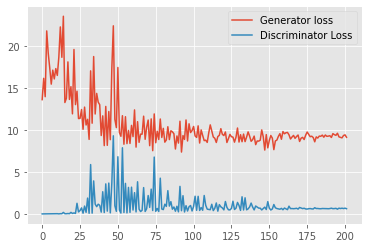

In [ ]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig(path + 'outputs/loss.png')